# Support Vector Machine

In questo notebook esploreremo Support Vector Machine (SVM), uno degli algoritmi più potenti per la classificazione. Implementeremo SVM da zero seguendo le fondamenta teoriche e vedremo come funziona su diversi dataset.


## 1. Introduzione a Support Vector Machine
Support Vector Machine è un algoritmo di apprendimento supervisionato utilizzato principalmente per problemi di classificazione. L'idea centrale di SVM è trovare l'iperpiano ottimale che separa le diverse classi con il margine massimo.

### Concetti chiave:

- **Decision Hyperplane**: Superficie che separa diverse classi
- **Margin**: Distanza dal decision boundary all'istanza di training più vicina
- **Margin extents**: Due iperpiani paralleli che definiscono il margine
- **Support Vectors**: Le istanze che si trovano lungo i margini e definiscono il boundary

<img src="https://upload.wikimedia.org/wikipedia/commons/7/72/SVM_margin.png" width="400" height="400">

## 2. Fondamenti Matematici

Per un problema di classificazione binaria, possiamo definire l'iperpiano di separazione come:

$$w_0 + \mathbf{w} \cdot \mathbf{x} = 0$$

Dove:

- $\mathbf{x} = (x_1, ..., x_D)$ rappresenta le D feature di un singolo punto dati
- $\mathbf{w} = (w_1, ..., w_D)$ sono i parametri del modello (vettore $\mathbf{w}$)
- $w_0$ è il bias

Istanze sopra l'iperpiano: $w_0 + \mathbf{w} \cdot \mathbf{x} > 0$ Istanze sotto l'iperpiano: $w_0 + \mathbf{w} \cdot \mathbf{x} < 0$

Per convenzione, impostiamo il livello target negativo a -1 e il livello target positivo a +1.

La distanza tra i margin extents è $\frac{2}{||\mathbf{w}||}$, quindi per massimizzare il margine dobbiamo minimizzare $||\mathbf{w}||$.

Questo porta al seguente problema di ottimizzazione:

$$\text{Minimizzare: } \frac{1}{2} ||\mathbf{w}||^2$$

$$t_n(w_0 + \mathbf{w} \cdot \mathbf{x}_n) \geq 1 \text{ per } n = 1, ..., N$$

dove $t_n \in [{-1, +1}]$ è l'etichetta di classe per l'n-esimo esempio.

### Lagrangiano e Forma Duale

Per risolvere questo problema di ottimizzazione vincolata, introduciamo i moltiplicatori di Lagrange:

$$\mathcal{L}(\mathbf{w}, w_0, \boldsymbol{\alpha}) = \frac{1}{2}||\mathbf{w}||^2 - \sum_{i=1}^{N} \alpha_i [t_i(w_0 + \mathbf{w} \cdot \mathbf{x}_i) - 1]$$

Derivando rispetto a $\mathbf{w}$ e $w_0$ e ponendo le derivate a zero, otteniamo:

$$\mathbf{w} = \sum_{i=1}^{N} \alpha_i t_i \mathbf{x}_i$$

$$\sum_{i=1}^{N} \alpha_i t_i = 0$$

Sostituendo nel Lagrangiano, otteniamo la forma duale:

$$\max_{\boldsymbol{\alpha}} \sum_{i=1}^{N} \alpha_i - \frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N} \alpha_i \alpha_j t_i t_j \mathbf{x}_i \cdot \mathbf{x}_j$$

$$\text{con } \alpha_i \geq 0 \text{ per tutti gli } i \text{ e } \sum_{i=1}^{N} \alpha_i t_i = 0$$

## 3. Creazione di un Dataset di Esempio

Iniziamo creando un dataset sintetico per testare la nostra implementazione:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Impostiamo un seed per la riproducibilità
np.random.seed(42)

def create_linearly_separable_dataset(n_samples=100, noise=0.1):
    """
    Crea un dataset linearmente separabile per classificazione binaria
    
    Parametri:
    n_samples -- numero totale di campioni
    noise -- livello di rumore da aggiungere
    
    Restituisce:
    X -- matrice delle feature di shape (n_samples, 2)
    y -- vettore delle etichette di shape (n_samples,) con valori {-1, 1}
    """
    # Generiamo due cluster di punti
    n_samples_per_class = n_samples // 2
    
    # Classe positiva
    X_positive = np.random.randn(n_samples_per_class, 2) * noise + np.array([2, 2])
    
    # Classe negativa
    X_negative = np.random.randn(n_samples_per_class, 2) * noise + np.array([-2, -2])
    
    # Combiniamo i dati
    X = np.vstack((X_positive, X_negative))
    y = np.array([1] * n_samples_per_class + [-1] * n_samples_per_class)
    
    # Mescoliamo i dati
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    
    return X, y

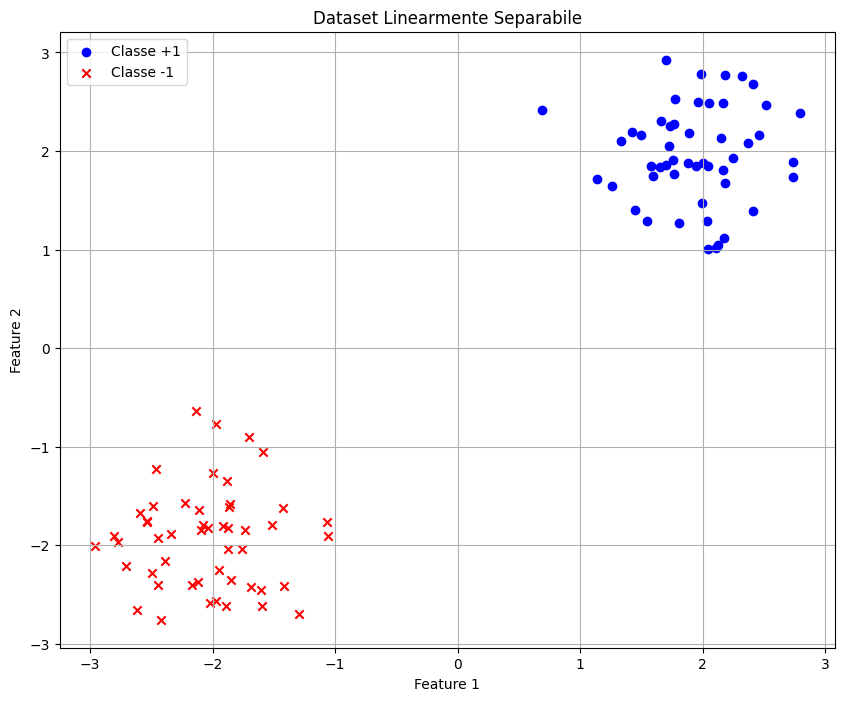

In [2]:
# Creiamo e visualizziamo il dataset
X, y = create_linearly_separable_dataset(n_samples=100, noise=0.5)

plt.figure(figsize=(10, 8))
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', label='Classe +1')
plt.scatter(X[y == -1, 0], X[y == -1, 1], color='red', marker='x', label='Classe -1')
plt.title('Dataset Linearmente Separabile')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

## 4. Implementazione di Linear SVM

Implementiamo una versione semplificata di SVM lineare usando la discesa del gradiente:

In [3]:
import numpy as np
import matplotlib.pyplot as plt

class LinearSVM:
    """
    Implementazione di SVM lineare utilizzando l'algoritmo SMO (Sequential Minimal Optimization)
    per risolvere il problema duale del Lagrangiano.
    
    Questo algoritmo risolve il problema duale:
    max Σ α_i - (1/2) Σ Σ α_i α_j y_i y_j (x_i · x_j)
    vincoli: Σ α_i y_i = 0, 0 ≤ α_i ≤ C
    
    Parametri:
    -----------
    C : float, default=1.0
        Parametro di regolarizzazione per il margine morbido.
    tol : float, default=1e-3
        Tolleranza per i criteri di convergenza.
    max_passes : int, default=5
        Numero massimo di passi senza cambiamenti significativi.
    max_iter : int, default=1000
        Numero massimo di iterazioni.
    """
    
    def __init__(self, C=1.0, tol=1e-3, max_passes=5, max_iter=1000):
        self.C = C
        self.tol = tol
        self.max_passes = max_passes
        self.max_iter = max_iter
        self.alphas = None
        self.b = 0
        self.w = None
        self.support_vector_indices = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.errors = None
    
    def _compute_error(self, i):
        """Calcola l'errore per il punto i"""
        f_i = np.dot(self.w, self.X[i]) + self.b
        return f_i - self.y[i]
        
    def _select_second_alpha(self, i):
        """Seleziona il secondo alpha per l'ottimizzazione"""
        errors = self.errors.copy()
        # Escludiamo l'errore di i
        valid_indices = np.arange(len(errors)) != i
        errors_valid = errors[valid_indices]
        indices_valid = np.arange(len(errors))[valid_indices]
        
        # Troviamo l'indice con il massimo errore rispetto a i
        if self.errors[i] > 0:
            j = indices_valid[np.argmin(errors_valid)]
        else:
            j = indices_valid[np.argmax(errors_valid)]
        
        return j
    
    def fit(self, X, y):
        """
        Addestra il modello SVM sui dati di training.
        
        Parametri:
        ----------
        X : array-like, shape (n_samples, n_features)
            Training vectors.
        y : array-like, shape (n_samples,)
            Target values, deve contenere -1 e 1 o 0 e 1.
        
        Returns:
        --------
        self : oggetto
            Ritorna self.
        """
        n_samples, n_features = X.shape
        
        # Convertiamo le etichette in -1/1
        self.y_original = y.copy()
        self.y = np.where(y <= 0, -1, 1)
        self.X = X
        
        # Inizializziamo gli alpha, w e b
        self.alphas = np.zeros(n_samples)
        self.w = np.zeros(n_features)
        self.b = 0
        
        # Inizializziamo gli errori
        self.errors = np.zeros(n_samples)
        for i in range(n_samples):
            self.errors[i] = self._compute_error(i)
        
        print("Inizio addestramento SVM...")
        
        # Implementazione dell'algoritmo SMO
        num_changed = 0
        examine_all = True
        passes = 0
        
        while (passes < self.max_passes) and (num_changed > 0 or examine_all):
            num_changed = 0
            
            if examine_all:
                # Esaminiamo tutti i punti
                for i in range(n_samples):
                    num_changed += self._examine_example(i)
            else:
                # Esaminiamo solo i punti con 0 < alpha < C
                non_bound_indices = np.where((self.alphas > 0) & (self.alphas < self.C))[0]
                for i in non_bound_indices:
                    num_changed += self._examine_example(i)
            
            if examine_all:
                examine_all = False
            elif num_changed == 0:
                examine_all = True
            
            passes += 1
            if passes % 10 == 0:
                print(f"Step {passes}, {num_changed} cambiamenti")
        
        # Identifichiamo i support vector
        sv_indices = np.where(self.alphas > self.tol)[0]
        self.support_vector_indices = sv_indices
        self.support_vectors = X[sv_indices]
        self.support_vector_labels = self.y[sv_indices]
        
        print(f"Addestramento completato in {passes} steps!")
        print(f"Numero di support vectors: {len(sv_indices)} su {n_samples} punti ({len(sv_indices)/n_samples*100:.1f}%)")
        print(f"Norma del vettore w: {np.linalg.norm(self.w):.6f}")
        
        return self
    
    def _examine_example(self, i):
        """Esamina un esempio e aggiorna gli alpha se necessario"""
        y_i = self.y[i]
        alpha_i = self.alphas[i]
        E_i = self.errors[i]
        r_i = E_i * y_i
        
        # Verifico se viola le condizioni KKT
        if ((r_i < -self.tol and alpha_i < self.C) or (r_i > self.tol and alpha_i > 0)):
            # Provo a ottimizzare con un secondo alpha
            j = self._select_second_alpha(i)
            return self._take_step(i, j)
        return 0
    
    def _take_step(self, i, j):
        """Esegue l'ottimizzazione per la coppia di alpha (i, j)"""
        if i == j:
            return 0
        
        alpha_i = self.alphas[i]
        alpha_j = self.alphas[j]
        y_i = self.y[i]
        y_j = self.y[j]
        E_i = self.errors[i]
        E_j = self.errors[j]
        
        # Calcolo i limiti L e H
        L, H = self._compute_bounds(i, j)
        if L == H:
            return 0
        
        # Calcolo eta = x_i·x_i + x_j·x_j - 2x_i·x_j
        eta = np.dot(self.X[i], self.X[i]) + np.dot(self.X[j], self.X[j]) - 2 * np.dot(self.X[i], self.X[j])
        
        if eta <= 0:
            # Questo non dovrebbe accadere con kernel positivi definiti
            return 0
        
        # Calcolo il nuovo valore di alpha_j
        alpha_j_new = alpha_j + y_j * (E_i - E_j) / eta
        
        # Limitiamo alpha_j ai vincoli
        if alpha_j_new > H:
            alpha_j_new = H
        elif alpha_j_new < L:
            alpha_j_new = L
        
        # Se il cambiamento è troppo piccolo, non facciamo nulla
        if abs(alpha_j_new - alpha_j) < 1e-5:
            return 0
        
        # Calcoliamo alpha_i_new
        alpha_i_new = alpha_i + y_i * y_j * (alpha_j - alpha_j_new)
        
        # Aggiorniamo il bias ----------------------------
        b_old = self.b
        
        # Aggiorniamo b in modo che gli errori siano 0 per i punti i e j
        b1 = b_old - E_i - y_i * (alpha_i_new - alpha_i) * np.dot(self.X[i], self.X[i]) - \
             y_j * (alpha_j_new - alpha_j) * np.dot(self.X[i], self.X[j])
             
        b2 = b_old - E_j - y_i * (alpha_i_new - alpha_i) * np.dot(self.X[i], self.X[j]) - \
             y_j * (alpha_j_new - alpha_j) * np.dot(self.X[j], self.X[j])
        
        if 0 < alpha_i_new < self.C:
            self.b = b1
        elif 0 < alpha_j_new < self.C:
            self.b = b2
        else:
            self.b = (b1 + b2) / 2
        
        # Aggiorniamo il vettore dei pesi
        self.w = self.w + y_i * (alpha_i_new - alpha_i) * self.X[i] + y_j * (alpha_j_new - alpha_j) * self.X[j]
        
        # Aggiorniamo gli alpha
        self.alphas[i] = alpha_i_new
        self.alphas[j] = alpha_j_new
        
        # Aggiorniamo gli errori
        for k in range(len(self.errors)):
            self.errors[k] = self._compute_error(k)
        
        return 1
    
    def _compute_bounds(self, i, j):
        """Calcola i limiti L e H per gli alpha"""
        if self.y[i] != self.y[j]:
            L = max(0, self.alphas[j] - self.alphas[i])
            H = min(self.C, self.C + self.alphas[j] - self.alphas[i])
        else:
            L = max(0, self.alphas[i] + self.alphas[j] - self.C)
            H = min(self.C, self.alphas[i] + self.alphas[j])
        return L, H
    
    def decision_function(self, X):
        """
        Calcola i valori della funzione di decisione.
        
        Parametri:
        ----------
        X : array-like, shape (n_samples, n_features)
            Punti da valutare.
            
        Returns:
        --------
        decision : array, shape (n_samples,)
            Valori della funzione di decisione.
        """
        return np.dot(X, self.w) + self.b    
    
    def predict_class(self, X):
        """
        Predice la classe originale (0 o 1) per i punti X.
        
        Parametri:
        ----------
        X : array-like, shape (n_samples, n_features)
            Punti da classificare.
            
        Returns:
        --------
        y_pred : array, shape (n_samples,)
            Classi predette (0 o 1).
        """
        raw_predictions = self.predict(X)
        # Convertiamo da -1/1 a 0/1
        if np.any(self.y_original == 0):
            return np.where(raw_predictions < 0, 0, 1)
        else:
            return raw_predictions
    

    def predict(self, X):
        """
        Predice la classe per i punti X.
        
        Parametri:
        ----------
        X : array-like, shape (n_samples, n_features)
            Punti da classificare.
            
        Returns:
        --------
        y_pred : array, shape (n_samples,)
            Classi predette (-1 o 1).
        """
        return np.sign(self.decision_function(X))
    def plot_decision_boundary(self, X, y, feature_indices=(0, 1), title="Confine di decisione SVM"):
        """
        Visualizza il confine di decisione SVM per due feature selezionate.
        
        Parametri:
        -----------
        X : array-like di shape (n_samples, n_features)
            Dataset
        y : array-like di shape (n_samples,)
            Etichette, in {0, 1} o {-1, 1}
        feature_indices : tuple, default=(0, 1)
            Indici delle due feature da visualizzare
        title : str
            Titolo del grafico
        """
        # Convertiamo le etichette 0/1 in -1/1 se necessario
        y_binary = np.where(y <= 0, -1, 1)
        
        # Estraiamo le due feature
        X_plot = X[:, feature_indices]
        
        # Creiamo una griglia per visualizzare il confine di decisione
        x_min, x_max = X_plot[:, 0].min() - 1, X_plot[:, 0].max() + 1
        y_min, y_max = X_plot[:, 1].min() - 1, X_plot[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                             np.arange(y_min, y_max, 0.02))
        
        # Prepariamo i punti della griglia
        grid_points = np.c_[xx.ravel(), yy.ravel()]
        
        # Se abbiamo più di due feature, dobbiamo aggiungere le altre feature
        if X.shape[1] > 2:
            # Calcoliamo i valori medi delle altre feature
            mean_values = X.mean(axis=0)
            
            # Creiamo una matrice di punti completa
            full_grid_points = np.zeros((grid_points.shape[0], X.shape[1]))
            for i in range(X.shape[1]):
                if i == feature_indices[0]:
                    full_grid_points[:, i] = grid_points[:, 0]
                elif i == feature_indices[1]:
                    full_grid_points[:, i] = grid_points[:, 1]
                else:
                    full_grid_points[:, i] = mean_values[i]
            
            # Calcoliamo i valori della funzione di decisione
            Z = self.decision_function(full_grid_points)
        else:
            # Se abbiamo solo due feature, possiamo usare direttamente i punti della griglia
            Z = self.decision_function(grid_points)
        
        # Riformattiamo Z per la visualizzazione
        Z = Z.reshape(xx.shape)
        
        plt.figure(figsize=(10, 8))
        
        # Visualizziamo il confine di decisione e i margini
        plt.contourf(xx, yy, Z, levels=[-1, 0, 1], alpha=0.5, 
                     colors=('skyblue', 'white', 'salmon'))
        plt.contour(xx, yy, Z, levels=[-1, 0, 1], colors=('blue', 'black', 'red'), 
                    linewidths=(1, 2, 1))
        
        # Visualizziamo i punti di training
        plt.scatter(X_plot[y_binary == 1, 0], X_plot[y_binary == 1, 1], 
                   c='red', marker='o', edgecolors='k', label='Classe 1')
        plt.scatter(X_plot[y_binary == -1, 0], X_plot[y_binary == -1, 1], 
                   c='blue', marker='s', edgecolors='k', label='Classe 0')
        
        # Evidenziamo i support vector
        if hasattr(self, 'support_vector_indices') and self.support_vector_indices is not None:
            plt.scatter(X_plot[self.support_vector_indices, 0], X_plot[self.support_vector_indices, 1], 
                       s=100, facecolors='none', edgecolors='green', linewidths=2, 
                       label='Support Vectors')
        
        plt.title(title)
        plt.xlabel(f'Feature {feature_indices[0]}')
        plt.ylabel(f'Feature {feature_indices[1]}')
        plt.legend()
        plt.tight_layout()
        plt.show()

In [4]:
# Addestriamo il modello SVM
svm = LinearSVM(C=0.1)
svm.fit(X, y)

# Testiamo le predizioni
y_pred = svm.predict(X)
accuracy = np.sum(y_pred == y) / len(y)
print(f"Accuratezza finale: {accuracy:.4f}")

Inizio addestramento SVM...
Addestramento completato in 3 steps!
Numero di support vectors: 2 su 100 punti (2.0%)
Norma del vettore w: 0.390366
Accuratezza finale: 1.0000


## 5. Visualizzazione del Decision Boundary

Creiamo una funzione per visualizzare il decision boundary e i support vectors:

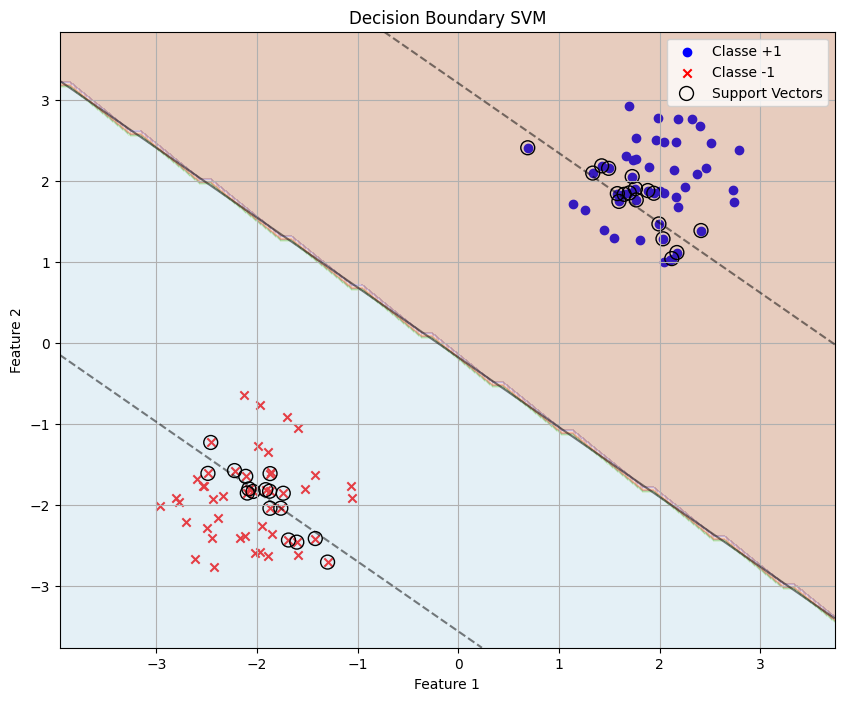

In [5]:
def plot_decision_boundary(model, X, y):
    """
    Visualizza il decision boundary di un modello SVM
    """
    plt.figure(figsize=(10, 8))
    
    # Plot dei punti
    plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', label='Classe +1')
    plt.scatter(X[y == -1, 0], X[y == -1, 1], color='red', marker='x', label='Classe -1')
    
    # Creiamo una griglia per visualizzare il decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    # Calcoliamo il valore della funzione di decisione sulla griglia
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Visualizziamo il decision boundary e i margini
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])
    
    # Coloriamo le regioni
    plt.contourf(xx, yy, np.sign(Z), alpha=0.3, cmap=plt.cm.Paired)
    
    # Evidenziamo i support vectors
    margins = y * model.decision_function(X)
    support_vector_indices = np.where(np.abs(margins - 1.0) < 0.1)[0]
    
    if len(support_vector_indices) > 0:
        plt.scatter(X[support_vector_indices, 0], X[support_vector_indices, 1], 
                   s=100, linewidth=1, facecolors='none', edgecolors='k', 
                   label='Support Vectors')
    
    plt.title('Decision Boundary SVM')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualizziamo il decision boundary
plot_decision_boundary(svm, X, y)


In [6]:
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np

def interactive_svm(C=0.1):
    """
    Addestra un SVM con il valore C specificato e mostra il decision boundary
    """
    # Addestriamo il modello SVM con il valore C corrente
    svm = LinearSVM(C=C)
    svm.fit(X, y)
    
    # Calcoliamo l'accuratezza
    y_pred = svm.predict(X)
    accuracy = np.sum(y_pred == y) / len(y)
    print(f"Accuratezza con C={C:.4f}: {accuracy:.4f}")
    
    # Visualizziamo il decision boundary usando la tua funzione
    plot_decision_boundary(svm, X, y)
    
    # Aggiungiamo il valore di C al titolo per maggiore chiarezza
    plt.title(f'Decision Boundary SVM (C={C:.4f})')
    plt.tight_layout()


interact(
    interactive_svm, 
    C=widgets.FloatLogSlider(
        value=0.1,
        base=10,
        min=-2,  # 10^-2 = 0.01
        max=2,   # 10^2 = 100
        step=0.1,
        description='C:',
        readout_format='.4f'
    )
)

interactive(children=(FloatLogSlider(value=0.1, description='C:', max=2.0, min=-2.0, readout_format='.4f'), Ou…

<function __main__.interactive_svm(C=0.1)>

**C regola il trade-off tra:**
- Massimizzare il margine (C piccolo)
- Minimizzare gli errori di classificazione (C grande)

**Valori di C piccoli**

Margine più ampio: Danno priorità alla massimizzazione dell'ampiezza del margine

Più tolleranza agli errori: Permettono più punti di training classificati erroneamente o all'interno del margine

Modello più semplice: Tendono a generare un decision boundary più regolare e meno complesso

Meno support vectors: Tipicamente hanno un numero inferiore di vettori di supporto

Possibile underfitting: Potrebbero non catturare sufficientemente la struttura dei dati


**Valori di C grandi**

Margine più stretto: Sacrificano l'ampiezza del margine per classificare correttamente più punti

Meno tolleranza agli errori: Cercano di classificare correttamente quanti più punti possibile

Modello più complesso: Il decision boundary può diventare più articolato

Più support vectors: Tendono ad avere più vettori di supporto

Possibile overfitting: Potrebbero adattarsi troppo ai dati di training


## Aumentiamo la difficoltà

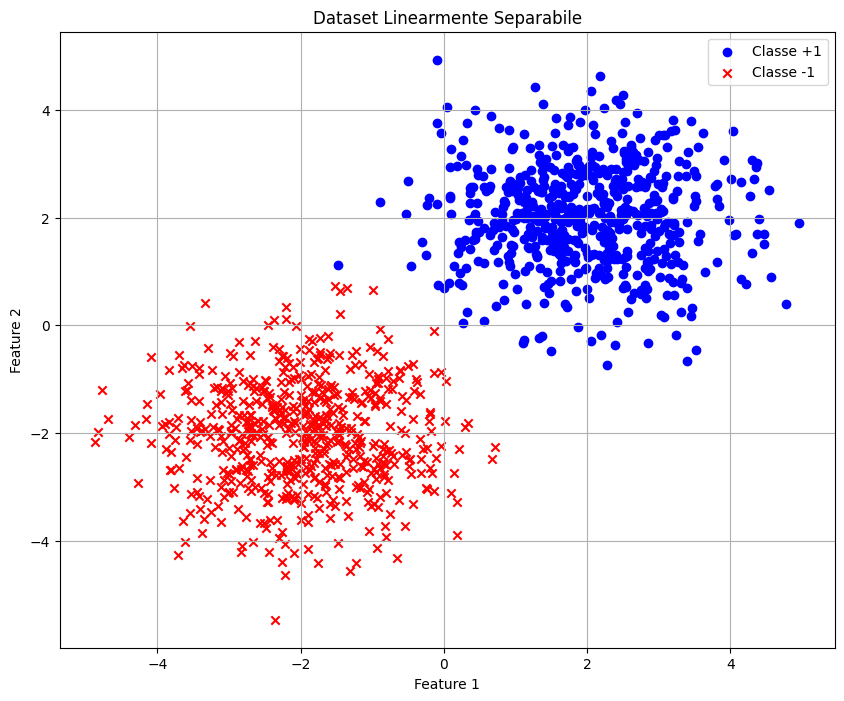

In [7]:
X, y = create_linearly_separable_dataset(n_samples=1200, noise=1)

plt.figure(figsize=(10, 8))
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', label='Classe +1')
plt.scatter(X[y == -1, 0], X[y == -1, 1], color='red', marker='x', label='Classe -1')
plt.title('Dataset Linearmente Separabile')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Addestriamo il modello SVM
svm = LinearSVM(C=10)
svm.fit(X, y)

# Testiamo le predizioni
y_pred = svm.predict(X)
accuracy = np.sum(y_pred == y) / len(y)
print(f"Accuratezza finale: {accuracy:.4f}")

Inizio addestramento SVM...
Addestramento completato in 3 steps!
Numero di support vectors: 4 su 1200 punti (0.3%)
Norma del vettore w: 0.510384
Accuratezza finale: 0.9408


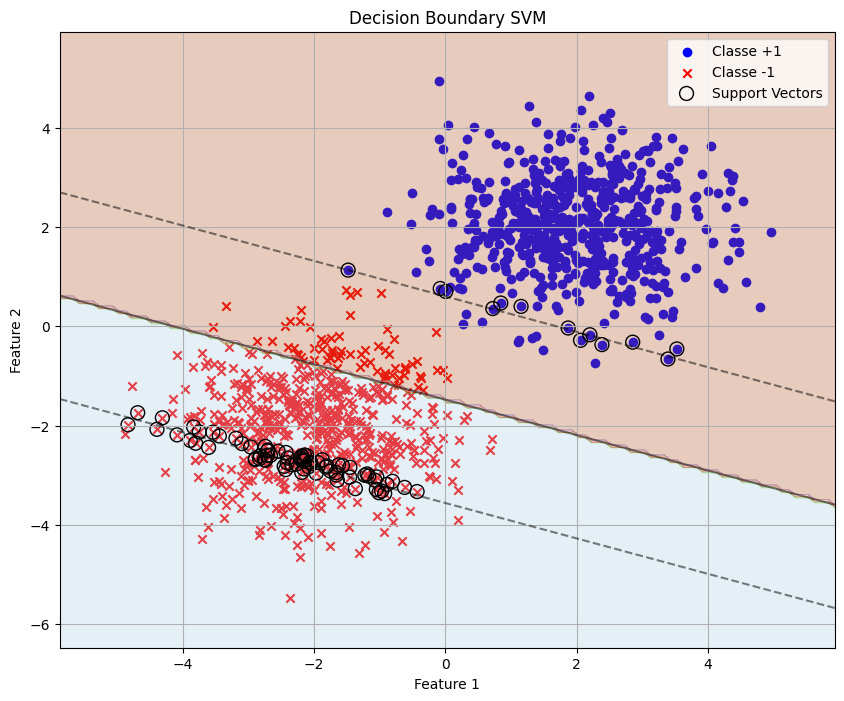

In [9]:
# Visualizziamo il decision boundary
plot_decision_boundary(svm, X, y)

## 6. Kernel SVM:
Una delle proprietà più potenti di SVM è la capacità di gestire dati non linearmente separabili attraverso l'utilizzo di kernels. L'idea è di mappare i dati in uno spazio di dimensione superiore dove diventano linearmente separabili.

I kernel più comuni sono:

1. **Kernel Lineare**: $K(\mathbf{x}_i, \mathbf{x}_j) = \mathbf{x}_i \cdot \mathbf{x}_j$
2. **Kernel Polinomiale**: $K(\mathbf{x}_i, \mathbf{x}_j) = (\mathbf{x}_i \cdot \mathbf{x}_j + 1)^d$
3. **Kernel RBF (Gaussiano)**: $K(\mathbf{x}_i, \mathbf{x}_j) = \exp(-\gamma ||\mathbf{x}_i - \mathbf{x}_j||^2)$

Implementiamo ora una versione di SVM con kernel:

In [10]:
class KernelSVM:
    """
    Implementazione di SVM con supporto per diversi kernel non lineari,
    utilizzando l'algoritmo SMO (Sequential Minimal Optimization).
    
    Questo algoritmo risolve il problema duale:
    max Σ α_i - (1/2) Σ Σ α_i α_j y_i y_j K(x_i, x_j)
    vincoli: Σ α_i y_i = 0, 0 ≤ α_i ≤ C
    
    Parametri:
    -----------
    C : float, default=1.0
        Parametro di regolarizzazione per il margine morbido.
    kernel : str, default='linear'
        Tipo di kernel da utilizzare. Opzioni: 'linear', 'poly', 'rbf', 'sigmoid'.
    degree : int, default=3
        Grado del kernel polinomiale (usato solo se kernel='poly').
    gamma : float, default='scale'
        Coefficiente del kernel. Usato per 'rbf', 'poly' e 'sigmoid'.
        Se 'scale', gamma = 1 / (n_features * X.var()).
        Se 'auto', gamma = 1 / n_features.
    coef0 : float, default=0.0
        Termine indipendente nel kernel polinomiale e sigmoide.
    tol : float, default=1e-3
        Tolleranza per i criteri di convergenza.
    max_passes : int, default=5
        Numero massimo di passate senza cambiamenti significativi.
    max_iter : int, default=1000
        Numero massimo di iterazioni per l'ottimizzazione di una coppia di alpha.
    random_state : int, default=None
        Seed per il generatore di numeri casuali.
    """
    
    def __init__(self, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0,
                 tol=1e-3, max_passes=5, max_iter=1000, random_state=None):
        self.C = C
        self.kernel_type = kernel
        self.degree = degree
        self.gamma = gamma
        self.coef0 = coef0
        self.tol = tol
        self.max_passes = max_passes
        self.max_iter = max_iter
        self.random_state = random_state
        # Attributi che verranno inizializzati durante il fit
        self.alphas = None
        self.b = 0.0
        self.support_vector_indices = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.support_vector_alphas = None
        self.X = None
        self.y = None
        self.y_original = None
        self.kernel_matrix = None
        self._gamma = None  # gamma calcolato
        self.w = None  # Solo per kernel lineare
        self.n_samples = None
        self.n_features = None
        self.errors = None
    
    def _compute_gamma(self, X):
        """Calcola il valore di gamma in base all'opzione selezionata"""
        n_features = X.shape[1]
        if self.gamma == 'scale':
            return 1.0 / (n_features * X.var())
        elif self.gamma == 'auto':
            return 1.0 / n_features
        else:
            return self.gamma
    
    def _linear_kernel(self, x1, x2):
        """Kernel lineare: K(x1, x2) = x1 · x2"""
        return np.dot(x1, x2)
    
    def _polynomial_kernel(self, x1, x2):
        """Kernel polinomiale: K(x1, x2) = (gamma * x1 · x2 + coef0)^degree"""
        return (self._gamma * np.dot(x1, x2) + self.coef0) ** self.degree
    
    def _rbf_kernel(self, x1, x2):
        """Kernel RBF (Gaussian): K(x1, x2) = exp(-gamma * ||x1 - x2||^2)"""
        return np.exp(-self._gamma * np.sum((x1 - x2) ** 2))
    
    def _sigmoid_kernel(self, x1, x2):
        """Kernel sigmoide: K(x1, x2) = tanh(gamma * x1 · x2 + coef0)"""
        return np.tanh(self._gamma * np.dot(x1, x2) + self.coef0)
    
    def _kernel_function(self, x1, x2):
        """Seleziona il kernel appropriato"""
        if self.kernel_type == 'linear':
            return self._linear_kernel(x1, x2)
        elif self.kernel_type == 'poly':
            return self._polynomial_kernel(x1, x2)
        elif self.kernel_type == 'rbf':
            return self._rbf_kernel(x1, x2)
        elif self.kernel_type == 'sigmoid':
            return self._sigmoid_kernel(x1, x2)
        else:
            raise ValueError(f"Kernel '{self.kernel_type}' non supportato")
    
    def _compute_kernel_matrix(self, X):
        """Calcola la matrice del kernel per tutti i punti"""
        n_samples = X.shape[0]
        K = np.zeros((n_samples, n_samples))
        
        for i in range(n_samples):
            for j in range(i, n_samples):
                K_ij = self._kernel_function(X[i], X[j])
                K[i, j] = K_ij
                K[j, i] = K_ij  # La matrice è simmetrica
        
        return K
    
    def _compute_error(self, i):
        """Calcola l'errore per il punto i"""
        if self.kernel_type == 'linear' and self.w is not None:
            # Per kernel lineare usiamo direttamente w·x + b
            f_i = np.dot(self.X[i], self.w) + self.b
        else:
            # Per kernel non lineari usiamo la formula duale
            f_i = self.b
            for j in range(len(self.alphas)):
                if self.alphas[j] > 0:  # Solo i support vector contribuiscono
                    f_i += self.alphas[j] * self.y[j] * self.kernel_matrix[j, i]
        
        return f_i - self.y[i]
    
    def _compute_bounds(self, i, j):
        """Calcola i limiti L e H per gli alphas"""
        if self.y[i] != self.y[j]:
            L = max(0, self.alphas[j] - self.alphas[i])
            H = min(self.C, self.C + self.alphas[j] - self.alphas[i])
        else:
            L = max(0, self.alphas[i] + self.alphas[j] - self.C)
            H = min(self.C, self.alphas[i] + self.alphas[j])
        return L, H
    
    def _select_second_alpha(self, i):
        """Seleziona il secondo alpha per l'ottimizzazione"""
        errors = self.errors.copy()
        valid_indices = np.arange(len(errors)) != i
        errors_valid = errors[valid_indices]
        indices_valid = np.arange(len(errors))[valid_indices]
        
        # Troviamo l'indice con il massimo errore rispetto a i
        if self.errors[i] > 0:
            j = indices_valid[np.argmin(errors_valid)]
        else:
            j = indices_valid[np.argmax(errors_valid)]
        
        return j
    
    def fit(self, X, y):
        """
        Addestra il modello SVM sui dati di training.
        
        Parametri:
        ----------
        X : array-like, shape (n_samples, n_features)
            Training vectors.
        y : array-like, shape (n_samples,)
            Target values, deve contenere -1 e 1 o 0 e 1.
        
        Returns:
        --------
        self : oggetto
            Ritorna self.
        """
        # Inizializzazione
        if self.random_state is not None:
            np.random.seed(self.random_state)
            
        self.n_samples, self.n_features = X.shape
        
        # Convertiamo le etichette in -1/1
        self.y_original = y.copy()
        self.y = np.where(y <= 0, -1, 1)
        self.X = X
        
        # Calcoliamo gamma
        self._gamma = self._compute_gamma(X)
        
        # Calcola la matrice del kernel
        print(f"Calcolo della matrice del kernel {self.kernel_type}...")
        self.kernel_matrix = self._compute_kernel_matrix(X)
        
        # Inizializziamo gli alpha, b e gli errori
        self.alphas = np.zeros(self.n_samples)
        self.b = 0
        self.errors = np.zeros(self.n_samples)
        
        for i in range(self.n_samples):
            self.errors[i] = self._compute_error(i)
        
        print(f"Inizio addestramento SVM con kernel {self.kernel_type} usando SMO...")
        
        # Implementazione dell'algoritmo SMO
        num_changed = 0
        examine_all = True
        passes = 0
        
        while (passes < self.max_passes) and (num_changed > 0 or examine_all):
            num_changed = 0
            
            if examine_all:
                # Esaminiamo tutti i punti
                for i in range(self.n_samples):
                    num_changed += self._examine_example(i)
            else:
                # Esaminiamo solo i punti con 0 < alpha < C
                non_bound_indices = np.where((self.alphas > 0) & (self.alphas < self.C))[0]
                for i in non_bound_indices:
                    num_changed += self._examine_example(i)
            
            if examine_all:
                examine_all = False
            elif num_changed == 0:
                examine_all = True
            
            passes += 1
            if passes % 5 == 0:
                print(f"Passata {passes}, {num_changed} cambiamenti")
        
        # Identifichiamo i support vector
        sv_indices = np.where(self.alphas > self.tol)[0]
        self.support_vector_indices = sv_indices
        self.support_vectors = X[sv_indices]
        self.support_vector_labels = self.y[sv_indices]
        self.support_vector_alphas = self.alphas[sv_indices]
        
        # Per kernel lineare, calcoliamo esplicitamente w
        if self.kernel_type == 'linear':
            self.w = np.zeros(self.n_features)
            for i in sv_indices:
                self.w += self.alphas[i] * self.y[i] * X[i]
        
        print(f"Addestramento completato in {passes} passate!")
        print(f"Numero di support vectors: {len(sv_indices)} su {self.n_samples} punti ({len(sv_indices)/self.n_samples*100:.1f}%)")
        
        if self.kernel_type == 'linear':
            print(f"Norma del vettore w: {np.linalg.norm(self.w):.6f}")
        
        return self
    
    def _examine_example(self, i):
        """Esamina un esempio e aggiorna gli alpha se necessario"""
        y_i = self.y[i]
        alpha_i = self.alphas[i]
        E_i = self.errors[i]
        r_i = E_i * y_i
        
        # Verifico se viola le condizioni KKT
        if ((r_i < -self.tol and alpha_i < self.C) or (r_i > self.tol and alpha_i > 0)):
            # Provo a ottimizzare con un secondo alpha
            j = self._select_second_alpha(i)
            return self._take_step(i, j)
        
        return 0
    
    def _take_step(self, i, j):
        """Esegue l'ottimizzazione per la coppia di alpha (i, j)"""
        if i == j:
            return 0
        
        alpha_i = self.alphas[i]
        alpha_j = self.alphas[j]
        y_i = self.y[i]
        y_j = self.y[j]
        E_i = self.errors[i]
        E_j = self.errors[j]
        
        # Calcolo i limiti L e H
        L, H = self._compute_bounds(i, j)
        if L == H:
            return 0
        
        # Calcolo eta = K_ii + K_jj - 2K_ij
        eta = self.kernel_matrix[i, i] + self.kernel_matrix[j, j] - 2 * self.kernel_matrix[i, j]
        
        if eta <= 0:
            # Questo può accadere con kernel non PSD (positivo semidefinito)
            return 0
        
        # Calcolo il nuovo valore di alpha_j
        alpha_j_new = alpha_j + y_j * (E_i - E_j) / eta
        
        # Limitiamo alpha_j ai vincoli
        if alpha_j_new > H:
            alpha_j_new = H
        elif alpha_j_new < L:
            alpha_j_new = L
        
        # Se il cambiamento è troppo piccolo, non facciamo nulla
        if abs(alpha_j_new - alpha_j) < 1e-5:
            return 0
        
        # Calcoliamo alpha_i_new
        alpha_i_new = alpha_i + y_i * y_j * (alpha_j - alpha_j_new)
        
        # Aggiorniamo il bias
        b_old = self.b
        
        # Aggiorniamo b in modo che gli errori siano 0 per i punti i e j
        b1 = b_old - E_i
        b1 -= y_i * (alpha_i_new - alpha_i) * self.kernel_matrix[i, i]
        b1 -= y_j * (alpha_j_new - alpha_j) * self.kernel_matrix[i, j]
             
        b2 = b_old - E_j
        b2 -= y_i * (alpha_i_new - alpha_i) * self.kernel_matrix[i, j]
        b2 -= y_j * (alpha_j_new - alpha_j) * self.kernel_matrix[j, j]
        
        if 0 < alpha_i_new < self.C:
            self.b = b1
        elif 0 < alpha_j_new < self.C:
            self.b = b2
        else:
            self.b = (b1 + b2) / 2
        
        # Aggiorniamo il vettore dei pesi per kernel lineare
        if self.kernel_type == 'linear' and self.w is not None:
            self.w = self.w + y_i * (alpha_i_new - alpha_i) * self.X[i] + y_j * (alpha_j_new - alpha_j) * self.X[j]
        
        # Aggiorniamo gli alpha
        self.alphas[i] = alpha_i_new
        self.alphas[j] = alpha_j_new
        
        # Aggiorniamo gli errori
        for k in range(len(self.errors)):
            self.errors[k] = self._compute_error(k)
        
        return 1
    
    def predict(self, X):
        """
        Predice la classe per i punti X.
        
        Parametri:
        ----------
        X : array-like, shape (n_samples, n_features)
            Punti da classificare.
            
        Returns:
        --------
        y_pred : array, shape (n_samples,)
            Classi predette (-1 o 1).
        """
        return np.sign(self.decision_function(X))
    
    def predict_class(self, X):
        """
        Predice la classe originale (0 o 1) per i punti X.
        
        Parametri:
        ----------
        X : array-like, shape (n_samples, n_features)
            Punti da classificare.
            
        Returns:
        --------
        y_pred : array, shape (n_samples,)
            Classi predette (0 o 1).
        """
        raw_predictions = self.predict(X)
        # Convertiamo da -1/1 a 0/1 se necessario
        if np.any(self.y_original == 0):
            return np.where(raw_predictions < 0, 0, 1)
        else:
            return raw_predictions
    
    def decision_function(self, X):
        """
        Calcola i valori della funzione di decisione.
        
        Parametri:
        ----------
        X : array-like, shape (n_samples, n_features)
            Punti da valutare.
            
        Returns:
        --------
        decision : array, shape (n_samples,)
            Valori della funzione di decisione.
        """
        # Per kernel lineare, possiamo usare w·x + b
        if self.kernel_type == 'linear' and self.w is not None:
            return np.dot(X, self.w) + self.b
        
        # Per kernel non lineari, usiamo la formulazione duale
        n_samples = X.shape[0]
        decision = np.zeros(n_samples)
        
        for i in range(n_samples):
            decision[i] = self.b
            
            # Sommiamo solo sui support vector per efficienza
            for j, sv_idx in enumerate(self.support_vector_indices):
                decision[i] += self.support_vector_alphas[j] * self.support_vector_labels[j] * \
                              self._kernel_function(self.support_vectors[j], X[i])
        
        return decision
    
    def plot_decision_boundary(self, X, y, feature_indices=(0, 1), title=None):
        """
        Visualizza il confine di decisione SVM per due feature selezionate.
        
        Parametri:
        -----------
        X : array-like di shape (n_samples, n_features)
            Dataset
        y : array-like di shape (n_samples,)
            Etichette, in {0, 1} o {-1, 1}
        feature_indices : tuple, default=(0, 1)
            Indici delle due feature da visualizzare
        title : str, optional
            Titolo del grafico. Se None, viene generato automaticamente.
        """
        if title is None:
            title = f"Confine di decisione SVM con kernel {self.kernel_type}"
            if self.kernel_type == 'poly':
                title += f" (grado {self.degree})"
            elif self.kernel_type in ['rbf', 'sigmoid']:
                title += f" (gamma {self._gamma:.4f})"
        
        # Convertiamo le etichette 0/1 in -1/1 se necessario
        y_binary = np.where(y <= 0, -1, 1)
        
        # Estraiamo le due feature
        X_plot = X[:, feature_indices]
        
        # Creiamo una griglia per visualizzare il confine di decisione
        x_min, x_max = X_plot[:, 0].min() - 1, X_plot[:, 0].max() + 1
        y_min, y_max = X_plot[:, 1].min() - 1, X_plot[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                             np.arange(y_min, y_max, 0.02))
        
        # Prepariamo i punti della griglia
        grid_points = np.c_[xx.ravel(), yy.ravel()]
        
        # Se abbiamo più di due feature, dobbiamo aggiungere le altre feature
        if X.shape[1] > 2:
            # Calcoliamo i valori medi delle altre feature
            mean_values = X.mean(axis=0)
            
            # Creiamo una matrice di punti completa
            full_grid_points = np.zeros((grid_points.shape[0], X.shape[1]))
            for i in range(X.shape[1]):
                if i == feature_indices[0]:
                    full_grid_points[:, i] = grid_points[:, 0]
                elif i == feature_indices[1]:
                    full_grid_points[:, i] = grid_points[:, 1]
                else:
                    full_grid_points[:, i] = mean_values[i]
            
            # Calcoliamo i valori della funzione di decisione
            Z = self.decision_function(full_grid_points)
        else:
            # Se abbiamo solo due feature, possiamo usare direttamente i punti della griglia
            Z = self.decision_function(grid_points)
        
        # Riformattiamo Z per la visualizzazione
        Z = Z.reshape(xx.shape)
        
        plt.figure(figsize=(10, 8))
        
        # Visualizziamo il confine di decisione e i margini
        plt.contourf(xx, yy, Z, levels=[-1, 0, 1], alpha=0.5, 
                     colors=('skyblue', 'white', 'salmon'))
        plt.contour(xx, yy, Z, levels=[-1, 0, 1], colors=('blue', 'black', 'red'), 
                    linewidths=(1, 2, 1))
        
        # Visualizziamo i punti di training
        plt.scatter(X_plot[y_binary == 1, 0], X_plot[y_binary == 1, 1], 
                   c='red', marker='o', edgecolors='k', label='Classe 1')
        plt.scatter(X_plot[y_binary == -1, 0], X_plot[y_binary == -1, 1], 
                   c='blue', marker='s', edgecolors='k', label='Classe 0')
        
        # Evidenziamo i support vector
        if hasattr(self, 'support_vector_indices') and self.support_vector_indices is not None:
            sv_indices_plot = self.support_vector_indices
            plt.scatter(X_plot[sv_indices_plot, 0], X_plot[sv_indices_plot, 1], 
                       s=100, facecolors='none', edgecolors='green', linewidths=2, 
                       label='Support Vectors')
        
        plt.title(title)
        plt.xlabel(f'Feature {feature_indices[0]}')
        plt.ylabel(f'Feature {feature_indices[1]}')
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    def visualize_kernel_space(self, X, y, n_components=2, title=None):
        """
        Visualizza i dati nello spazio del kernel usando PCA.
        Questo è utile per vedere come il kernel trasforma i dati per renderli separabili.
        
        Parametri:
        -----------
        X : array-like di shape (n_samples, n_features)
            Dataset
        y : array-like di shape (n_samples,)
            Etichette, in {0, 1} o {-1, 1}
        n_components : int, default=2
            Numero di componenti da visualizzare (1, 2 o 3)
        title : str, optional
            Titolo del grafico
        """
        from sklearn.decomposition import KernelPCA
        
        if title is None:
            title = f"Proiezione PCA dei dati con kernel {self.kernel_type}"
            if self.kernel_type == 'poly':
                title += f" (grado {self.degree})"
            elif self.kernel_type in ['rbf', 'sigmoid']:
                title += f" (gamma {self._gamma:.4f})"
        
        # Convertiamo le etichette 0/1 in -1/1 se necessario
        y_binary = np.where(y <= 0, -1, 1)
        
        # Configurazione del KernelPCA in base al kernel utilizzato
        kpca_params = {'n_components': n_components, 'kernel': self.kernel_type}
        
        if self.kernel_type == 'poly':
            kpca_params.update({'degree': self.degree, 'gamma': self._gamma, 'coef0': self.coef0})
        elif self.kernel_type in ['rbf', 'sigmoid']:
            kpca_params.update({'gamma': self._gamma})
            if self.kernel_type == 'sigmoid':
                kpca_params.update({'coef0': self.coef0})
        
        # Trasformiamo i dati usando KernelPCA
        kpca = KernelPCA(**kpca_params)
        X_kpca = kpca.fit_transform(X)
        
        # Visualizziamo i dati trasformati
        if n_components == 1:
            plt.figure(figsize=(10, 6))
            plt.scatter(X_kpca[y_binary == 1], np.zeros_like(X_kpca[y_binary == 1]), 
                       c='red', marker='o', edgecolors='k', label='Classe 1')
            plt.scatter(X_kpca[y_binary == -1], np.zeros_like(X_kpca[y_binary == -1]), 
                       c='blue', marker='s', edgecolors='k', label='Classe 0')
            plt.axvline(x=0, color='black', linestyle='-', linewidth=2)
            plt.title(title)
            plt.xlabel('Prima componente principale')
            plt.legend()
            
        elif n_components == 2:
            plt.figure(figsize=(10, 8))
            plt.scatter(X_kpca[y_binary == 1, 0], X_kpca[y_binary == 1, 1], 
                       c='red', marker='o', edgecolors='k', label='Classe 1')
            plt.scatter(X_kpca[y_binary == -1, 0], X_kpca[y_binary == -1, 1], 
                       c='blue', marker='s', edgecolors='k', label='Classe 0')
            
            # Evidenziamo i support vector
            if hasattr(self, 'support_vector_indices') and self.support_vector_indices is not None:
                sv_indices = self.support_vector_indices
                sv_kpca = kpca.transform(X[sv_indices])
                plt.scatter(sv_kpca[:, 0], sv_kpca[:, 1], 
                           s=100, facecolors='none', edgecolors='green', linewidths=2, 
                           label='Support Vectors')
            
            plt.title(title)
            plt.xlabel('Prima componente principale')
            plt.ylabel('Seconda componente principale')
            plt.legend()
            
        elif n_components == 3:
            from mpl_toolkits.mplot3d import Axes3D
            
            fig = plt.figure(figsize=(12, 10))
            ax = fig.add_subplot(111, projection='3d')
            
            ax.scatter(X_kpca[y_binary == 1, 0], X_kpca[y_binary == 1, 1], X_kpca[y_binary == 1, 2],
                      c='red', marker='o', edgecolors='k', label='Classe 1')
            ax.scatter(X_kpca[y_binary == -1, 0], X_kpca[y_binary == -1, 1], X_kpca[y_binary == -1, 2],
                      c='blue', marker='s', edgecolors='k', label='Classe 0')
            
            # Evidenziamo i support vector
            if hasattr(self, 'support_vector_indices') and self.support_vector_indices is not None:
                sv_indices = self.support_vector_indices
                sv_kpca = kpca.transform(X[sv_indices])
                ax.scatter(sv_kpca[:, 0], sv_kpca[:, 1], sv_kpca[:, 2],
                          s=100, facecolors='none', edgecolors='green', linewidths=2, 
                          label='Support Vectors')
            
            ax.set_title(title)
            ax.set_xlabel('Prima componente principale')
            ax.set_ylabel('Seconda componente principale')
            ax.set_zlabel('Terza componente principale')
            ax.legend()
        
        plt.tight_layout()
        plt.show()

## 7. Dataset Non Linearmente Separabile

Creiamo un dataset che non è linearmente separabile:

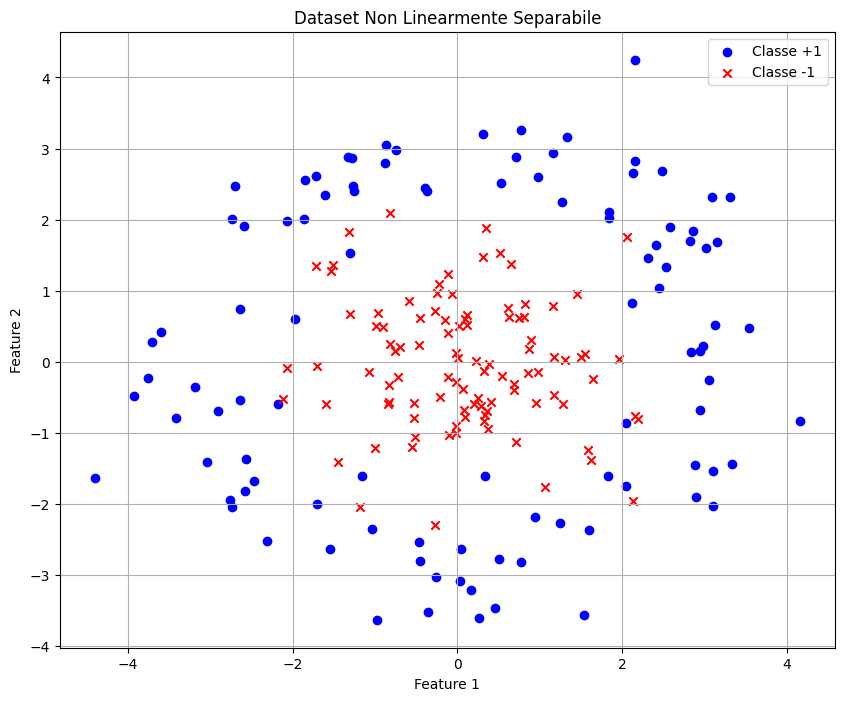

In [11]:
def create_nonlinear_dataset(n_samples=200, noise=0.1):
    """
    Crea un dataset non linearmente separabile (forma circolare)
    """
    np.random.seed(42)
    
    # Creiamo punti in un cerchio per la classe positiva
    radius = 3.0
    theta = np.random.uniform(0, 2*np.pi, n_samples//2)
    X_positive = np.zeros((n_samples//2, 2))
    X_positive[:, 0] = radius * np.cos(theta)
    X_positive[:, 1] = radius * np.sin(theta)
    X_positive += np.random.normal(0, noise, X_positive.shape)
    
    # Creiamo punti centrali per la classe negativa
    X_negative = np.random.normal(0, 1, (n_samples//2, 2))
    
    # Combiniamo i dati
    X = np.vstack((X_positive, X_negative))
    y = np.array([1] * (n_samples//2) + [-1] * (n_samples//2))
    
    # Mescoliamo i dati
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    
    return X, y

# Creiamo e visualizziamo il dataset
X_nonlinear, y_nonlinear = create_nonlinear_dataset(n_samples=200, noise=0.5)

plt.figure(figsize=(10, 8))
plt.scatter(X_nonlinear[y_nonlinear == 1, 0], X_nonlinear[y_nonlinear == 1, 1], 
            color='blue', marker='o', label='Classe +1')
plt.scatter(X_nonlinear[y_nonlinear == -1, 0], X_nonlinear[y_nonlinear == -1, 1], 
            color='red', marker='x', label='Classe -1')
plt.title('Dataset Non Linearmente Separabile')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

Addestriamo SVM con diversi kernel sul dataset non lineare

Calcolo della matrice del kernel linear...
Inizio addestramento SVM con kernel linear usando SMO...
Passata 5, 30 cambiamenti
Addestramento completato in 5 passate!
Numero di support vectors: 129 su 200 punti (64.5%)
Norma del vettore w: 0.726857


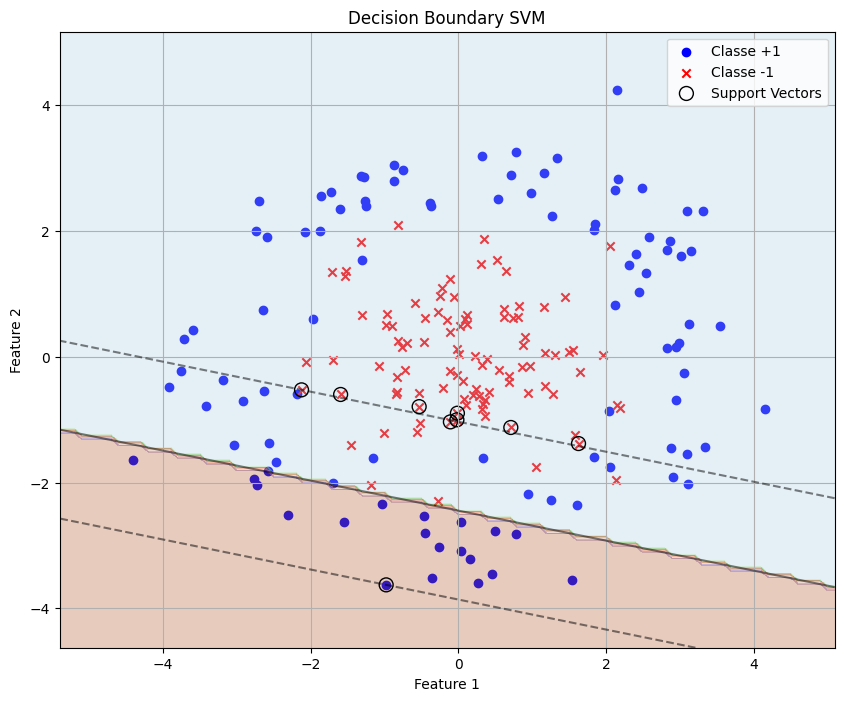

Accuratezza finale: 0.5950


In [12]:
# Addestriamo SVM con kernel lineare
svm_linear = KernelSVM(C=10, kernel='linear', max_iter=1000)
svm_linear.fit(X_nonlinear, y_nonlinear)
plot_decision_boundary(svm_linear, X_nonlinear, y_nonlinear)
#accuracy
y_pred = svm_linear.predict(X_nonlinear)
accuracy = np.sum(y_pred == y_nonlinear) / len(y_nonlinear)
print(f"Accuratezza finale: {accuracy:.4f}")


Calcolo della matrice del kernel poly...
Inizio addestramento SVM con kernel poly usando SMO...
Addestramento completato in 4 passate!
Numero di support vectors: 75 su 200 punti (37.5%)


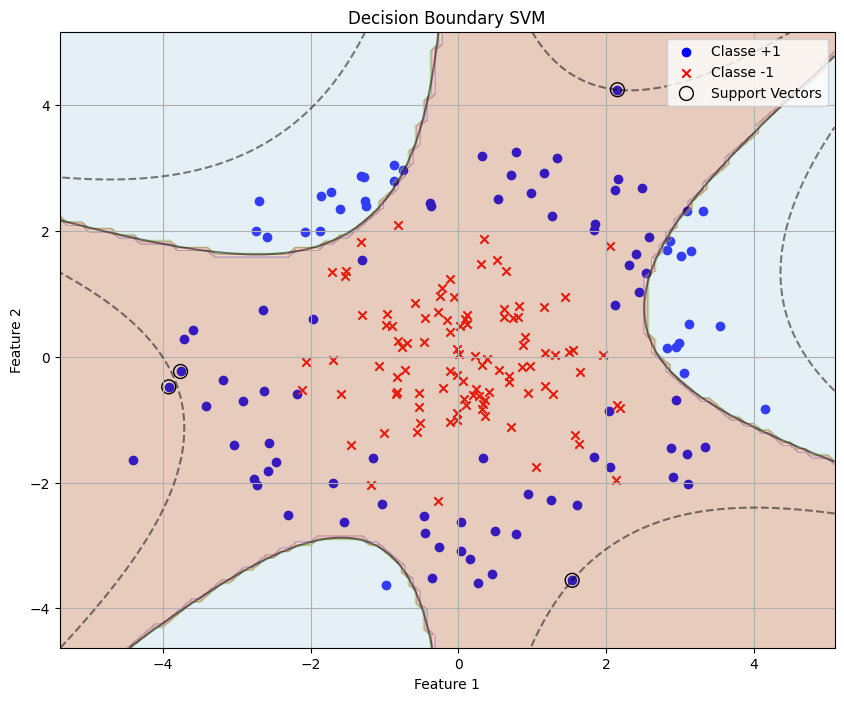

Accuratezza finale: 0.3550


In [13]:
# Addestriamo SVM con kernel polinomiale
svm_poly = KernelSVM(C=1.0, kernel='poly', degree=3, max_iter=100)
svm_poly.fit(X_nonlinear, y_nonlinear)
# Visualizziamo il confine di decisione
plot_decision_boundary(svm_poly, X_nonlinear, y_nonlinear)
#accuracy
y_pred = svm_poly.predict(X_nonlinear)
accuracy = np.sum(y_pred == y_nonlinear) / len(y_nonlinear)
print(f"Accuratezza finale: {accuracy:.4f}")



Calcolo della matrice del kernel rbf...
Inizio addestramento SVM con kernel rbf usando SMO...
Addestramento completato in 3 passate!
Numero di support vectors: 18 su 200 punti (9.0%)


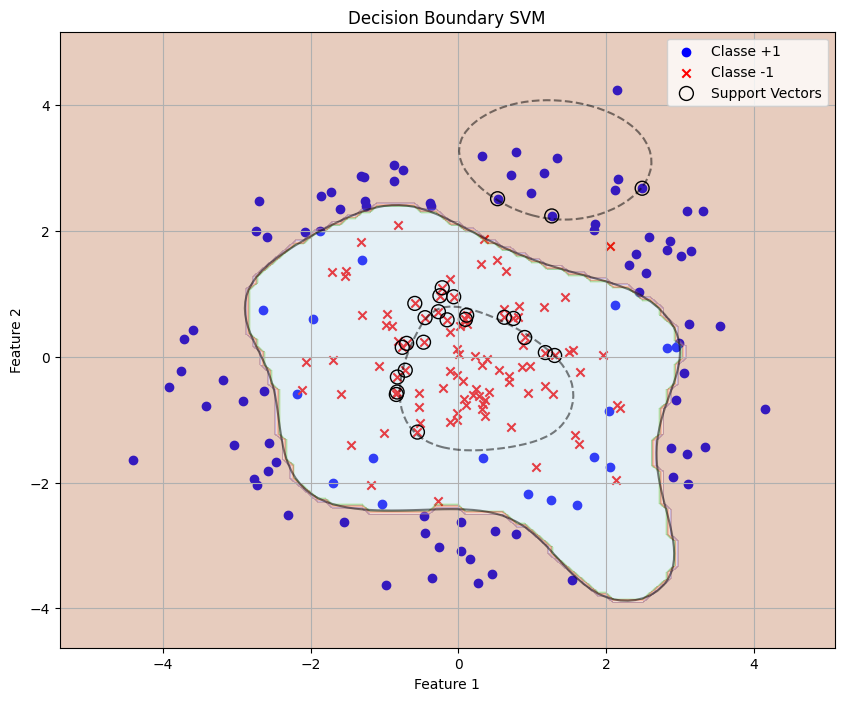

Accuratezza finale con kernel RBF: 0.9050


In [14]:
# Addestriamo SVM con kernel RBF
svm_rbf = KernelSVM(C=1.0, kernel='rbf', gamma=0.5, max_iter=100)
svm_rbf.fit(X_nonlinear, y_nonlinear)
plot_decision_boundary(svm_rbf, X_nonlinear, y_nonlinear)
#accuracy
y_pred_rbf = svm_rbf.predict(X_nonlinear)
accuracy_rbf = np.sum(y_pred_rbf == y_nonlinear) / len(y_nonlinear)
print(f"Accuratezza finale con kernel RBF: {accuracy_rbf:.4f}")

Visualizziamo i decision boundary per ciascun kernel:

Calcolo della matrice del kernel rbf...
Inizio addestramento SVM con kernel rbf usando SMO...
Addestramento completato in 3 passate!
Numero di support vectors: 33 su 200 punti (16.5%)
Calcolo della matrice del kernel rbf...
Inizio addestramento SVM con kernel rbf usando SMO...
Addestramento completato in 3 passate!
Numero di support vectors: 14 su 200 punti (7.0%)
Calcolo della matrice del kernel rbf...
Inizio addestramento SVM con kernel rbf usando SMO...
Addestramento completato in 3 passate!
Numero di support vectors: 14 su 200 punti (7.0%)


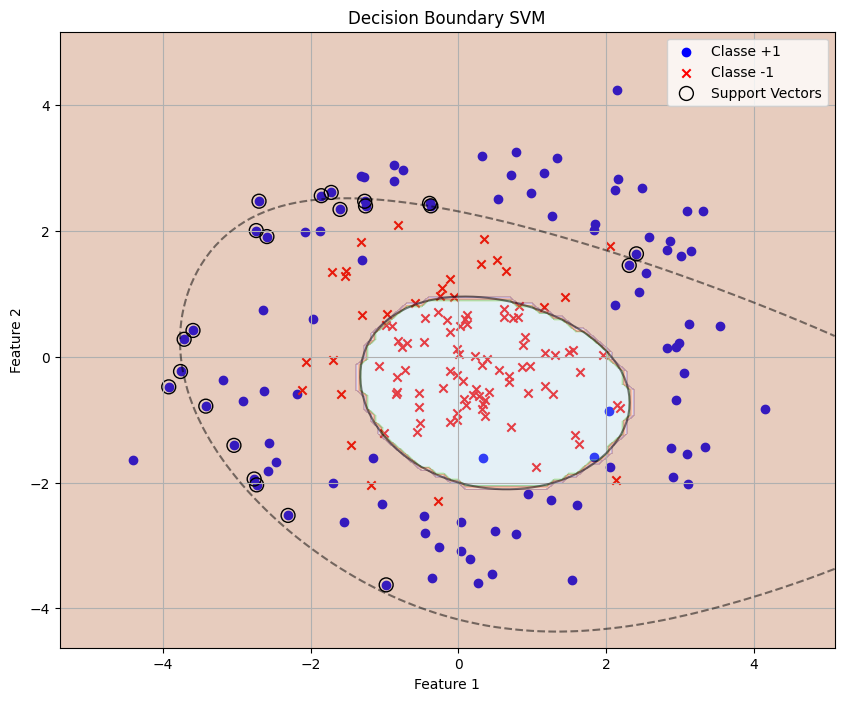

Accuratezza C=100.0: 0.8800
C=100.0: Hard Margin


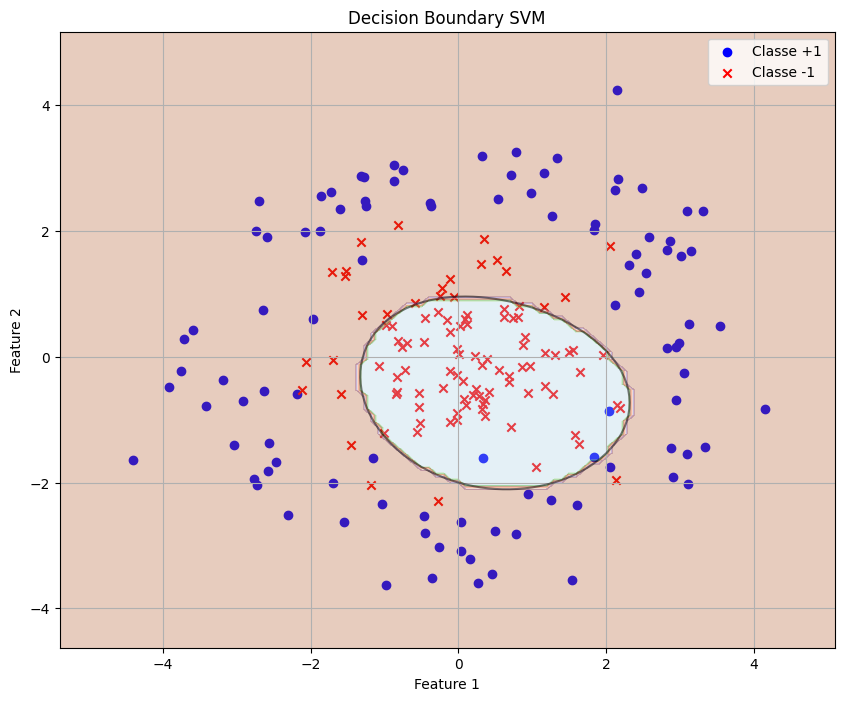

Accuratezza C=1.0: 0.8500
C=1.0: Bilanciato


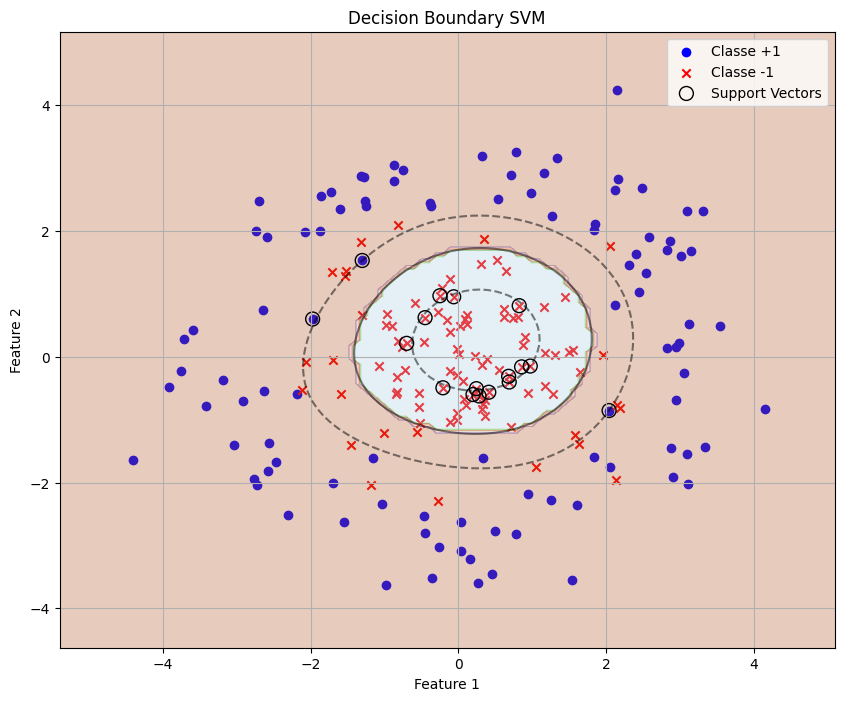

Accuratezza C=0.1: 0.8500
C=0.1: Soft Margin


In [15]:
# Addestriamo SVM con diversi valori di C

svm_c_large = KernelSVM(C=100.0, kernel='rbf', gamma=0.1, max_iter=100)
svm_c_large.fit(X_nonlinear, y_nonlinear)


svm_c_medium = KernelSVM(C=1.0, kernel='rbf', gamma=0.1, max_iter=100)
svm_c_medium.fit(X_nonlinear, y_nonlinear)


svm_c_small = KernelSVM(C=0.1, kernel='rbf', gamma=0.1, max_iter=100)
svm_c_small.fit(X_nonlinear, y_nonlinear)

plot_decision_boundary(svm_c_medium, X_nonlinear, y_nonlinear)
print(f"Accuratezza C=100.0: {np.sum(svm_c_large.predict(X_nonlinear) == y_nonlinear) / len(y_nonlinear):.4f}")
print("C=100.0: Hard Margin")

plot_decision_boundary(svm_c_small, X_nonlinear, y_nonlinear)
print(f"Accuratezza C=1.0: {np.sum(svm_c_medium.predict(X_nonlinear) == y_nonlinear) / len(y_nonlinear):.4f}")
print("C=1.0: Bilanciato")
plot_decision_boundary(svm_c_large, X_nonlinear, y_nonlinear)
print(f"Accuratezza C=0.1: {np.sum(svm_c_small.predict(X_nonlinear) == y_nonlinear) / len(y_nonlinear):.4f}")
print("C=0.1: Soft Margin")

### Usiamo ora sklearn che offre una versione ottimizzata

In [ ]:
# Esempio di utilizzo di scikit-learn per confronto
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
# Addestramento di SVM con scikit-learn
sklearn_svm = SVC(kernel='rbf', C=1.0, gamma=0.1)
sklearn_svm.fit(X_nonlinear, y_nonlinear)

# Accuratezza
y_pred_sklearn = sklearn_svm.predict(X_nonlinear)
accuracy_sklearn = accuracy_score(y_nonlinear, y_pred_sklearn)
print(f"Accuratezza con scikit-learn: {accuracy_sklearn:.4f}")

# Confronto con la nostra implementazione
y_pred_custom = svm_c_medium.predict(X_nonlinear)
accuracy_custom = accuracy_score(y_nonlinear, y_pred_custom)
print(f"Accuratezza con la nostra implementazione: {accuracy_custom:.4f}")

Accuratezza con scikit-learn: 0.9400
Accuratezza con la nostra implementazione: 0.8500


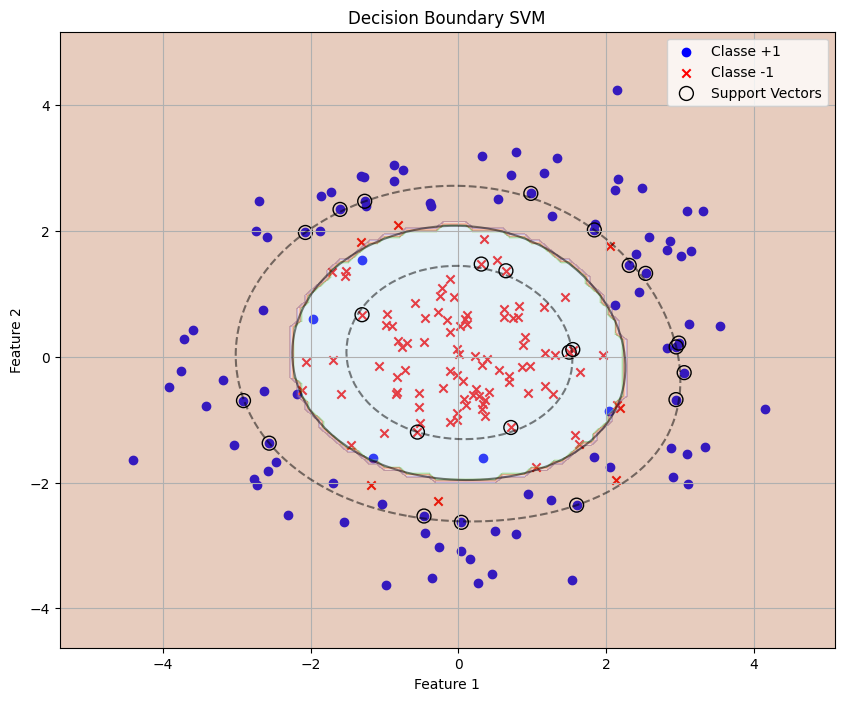

In [17]:
plot_decision_boundary(sklearn_svm, X_nonlinear, y_nonlinear)

## Come estendiamo SVM ai problemi multicalasse?

### SVM Multiclasse
SVM è stato originariamente progettato per la classificazione binaria, ma esistono diverse strategie per estenderlo a problemi multiclasse
### Principali approcci per SVM multiclasse:

1. **One-vs-All (OVA)**: Si addestrano K classificatori, uno per ogni classe contro tutte le altre
2. **One-vs-One (OVO)**: Si addestrano K(K-1)/2 classificatori, uno per ogni coppia di classi
Implementiamo entrambi questi approcci:

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# Importiamo le nostre implementazioni SVM dal modulo precedente
# Assumiamo che LinearSVM e KernelSVM siano disponibili

class SVMMulticlassOVA:
    """
    Implementazione universale di SVM multiclasse usando l'approccio One-vs-All (OVA).
    Funziona con qualsiasi tipo di etichette (numeri, stringhe, etc.).
    """
    
    def __init__(self, svm_class=None, **svm_params):
        """
        Inizializzazione del modello
        
        Parametri:
        svm_class -- classe SVM da utilizzare (deve avere metodi fit, predict)
        svm_params -- parametri da passare al classificatore SVM
        """
        self.svm_class = svm_class  # Classe del classificatore SVM da utilizzare
        self.svm_params = svm_params
        self.classifiers = []
        self.classes = None
    
    def fit(self, X, y):
        """
        Addestra un classificatore SVM per ogni classe usando l'approccio OVA
        
        Parametri:
        X -- matrice delle feature
        y -- vettore delle etichette
        """
        # Memorizziamo le classi originali (qualsiasi tipo)
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        
        print(f"Addestramento di {n_classes} classificatori SVM (OVA)...")
        
        # Addestriamo un classificatore per ogni classe
        for i, current_class in enumerate(self.classes):
            print(f"Classificatore {i+1}/{n_classes} per classe {current_class} vs resto")
            
            # Creiamo etichette binarie: 1 per la classe corrente, -1 per tutte le altre
            y_binary = np.ones(len(y)) * -1
            y_binary[y == current_class] = 1
            
            # Creiamo il classificatore
            if self.svm_class is None:
                # Se non è specificata una classe, utilizziamo LinearSVM
                classifier = LinearSVM(**self.svm_params)
            else:
                # Altrimenti usiamo la classe specificata
                classifier = self.svm_class(**self.svm_params)
            
            # Addestriamo il classificatore
            classifier.fit(X, y_binary)
            
            # Aggiungiamo il classificatore alla lista
            self.classifiers.append(classifier)
        
        print("Addestramento OVA completato!")
        return self
    
    def decision_function(self, X):
        """
        Calcola i punteggi di confidenza per ogni classe
        
        Parametri:
        X -- matrice delle feature
        
        Restituisce:
        scores -- matrice dei punteggi (n_samples, n_classes)
        """
        n_samples = X.shape[0]
        n_classes = len(self.classes)
        
        # Matrice dei punteggi: ogni riga è un campione, ogni colonna è una classe
        scores = np.zeros((n_samples, n_classes))
        
        # Calcoliamo i punteggi per ogni classificatore
        for i, classifier in enumerate(self.classifiers):
            # Prima proviamo con decision_function
            if hasattr(classifier, 'decision_function'):
                scores[:, i] = classifier.decision_function(X)
            else:
                # Se non disponibile, usiamo predict come fallback
                raw_predictions = classifier.predict(X)
                # Convertiamo in valori numerici se necessario
                if isinstance(raw_predictions[0], (str, bool)):
                    scores[:, i] = np.where(raw_predictions == 1, 1.0, -1.0)
                else:
                    scores[:, i] = raw_predictions
        
        return scores
    
    def predict(self, X):
        """
        Predice la classe con la massima confidenza
        
        Parametri:
        X -- matrice delle feature
        
        Restituisce:
        y_pred -- vettore delle classi predette
        """
        # Calcoliamo i punteggi per ogni classe
        scores = self.decision_function(X)
        
        # La classe predetta è quella con il punteggio più alto
        predicted_indices = np.argmax(scores, axis=1)
        
        # Mappiamo gli indici alle classi originali
        return self.classes[predicted_indices]
    
    def score(self, X, y):
        """
        Calcola l'accuratezza del modello
        
        Parametri:
        X -- matrice delle feature
        y -- vettore delle etichette reali
        
        Restituisce:
        accuracy -- accuratezza del modello
        """
        return accuracy_score(y, self.predict(X))
    
    def plot_confusion_matrix(self, X, y, title="Matrice di Confusione - SVM OVA"):
        """
        Visualizza la matrice di confusione
        
        Parametri:
        X -- matrice delle feature
        y -- vettore delle etichette reali
        title -- titolo del grafico
        """
        y_pred = self.predict(X)
        cm = confusion_matrix(y, y_pred)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predizione')
        plt.ylabel('Reale')
        plt.title(title)
        plt.xticks(np.arange(len(self.classes)) + 0.5, self.classes)
        plt.yticks(np.arange(len(self.classes)) + 0.5, self.classes)
        plt.tight_layout()
        plt.show()
        
        accuracy = accuracy_score(y, y_pred)
        print(f"Accuratezza: {accuracy:.4f}")
        
        return cm, accuracy

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from itertools import combinations

class SVMMulticlassOVO:
    """
    Implementazione di SVM multiclasse usando l'approccio One-vs-One (OVO).
    Funziona con qualsiasi tipo di etichette (numeri, stringhe, etc.).
    
    Nell'approccio OVO, addestriamo un classificatore binario per ogni coppia di classi,
    per un totale di n*(n-1)/2 classificatori, dove n è il numero di classi.
    """
    
    def __init__(self, svm_class=None, **svm_params):
        """
        Inizializzazione del modello
        
        Parametri:
        svm_class -- classe SVM da utilizzare (deve avere metodi fit, predict)
        svm_params -- parametri da passare al classificatore SVM
        """
        self.svm_class = svm_class  # Classe del classificatore SVM da utilizzare
        self.svm_params = svm_params
        self.classifiers = []  # Lista di tuple (classificatore, classe_i, classe_j)
        self.classes = None
    
    def fit(self, X, y):
        """
        Addestra un classificatore SVM per ogni coppia di classi usando l'approccio OVO
        
        Parametri:
        X -- matrice delle feature
        y -- vettore delle etichette
        """
        # Memorizziamo le classi originali (qualsiasi tipo)
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        
        # Calcoliamo il numero di classificatori necessari
        n_classifiers = n_classes * (n_classes - 1) // 2
        print(f"Addestramento di {n_classifiers} classificatori SVM (OVO)...")
        
        # Generiamo tutte le coppie di classi
        class_pairs = list(combinations(range(n_classes), 2))
        
        # Addestriamo un classificatore per ogni coppia di classi
        for idx, (i, j) in enumerate(class_pairs):
            class_i = self.classes[i]
            class_j = self.classes[j]
            print(f"Classificatore {idx+1}/{n_classifiers}: classe {class_i} vs classe {class_j}")
            
            # Filtriamo i dati per le due classi
            mask = np.logical_or(y == class_i, y == class_j)
            X_subset = X[mask]
            y_subset = y[mask]
            
            # Creiamo etichette binarie: +1 per classe_i, -1 per classe_j
            y_binary = np.ones(len(y_subset)) * -1
            y_binary[y_subset == class_i] = 1
            
            # Creiamo il classificatore
            if self.svm_class is None:
                # Se non è specificata una classe, utilizziamo LinearSVM
                classifier = LinearSVM(**self.svm_params)
            else:
                # Altrimenti usiamo la classe specificata
                classifier = self.svm_class(**self.svm_params)
            
            # Addestriamo il classificatore
            classifier.fit(X_subset, y_binary)
            
            # Aggiungiamo il classificatore alla lista con le informazioni sulle classi
            self.classifiers.append((classifier, class_i, class_j))
        
        print("Addestramento OVO completato!")
        return self
    
    def predict(self, X):
        """
        Predice la classe usando il voto di maggioranza tra tutti i classificatori
        
        Parametri:
        X -- matrice delle feature
        
        Restituisce:
        y_pred -- vettore delle classi predette
        """
        n_samples = X.shape[0]
        n_classes = len(self.classes)
        
        # Matrice dei voti: ogni riga è un campione, ogni colonna è una classe
        votes = np.zeros((n_samples, n_classes))
        
        # Per ogni classificatore binario
        for classifier, class_i, class_j in self.classifiers:
            # Otteniamo le predizioni
            predictions = classifier.predict(X)
            
            # Troviamo l'indice della classe_i e classe_j
            i = np.where(self.classes == class_i)[0][0]
            j = np.where(self.classes == class_j)[0][0]
            
            # Aggiungiamo un voto per la classe predetta
            for k in range(n_samples):
                if predictions[k] > 0:  # Classe i vince
                    votes[k, i] += 1
                else:  # Classe j vince
                    votes[k, j] += 1
        
        # La classe predetta è quella con il massimo numero di voti
        predicted_indices = np.argmax(votes, axis=1)
        
        # Debug: stampiamo la distribuzione dei voti per alcuni esempi
        if n_samples > 0:
            print("\nEsempio di voti per 3 istanze:")
            for k in range(min(3, n_samples)):
                vote_str = " ".join([f"{self.classes[i]}: {votes[k, i]}" for i in range(n_classes)])
                print(f"Istanza {k}: {vote_str} → Predizione: {self.classes[predicted_indices[k]]}")
        
        # Mappiamo gli indici alle classi originali
        return self.classes[predicted_indices]
    
    def decision_function(self, X):
        """
        Calcola una matrice di confidenza basata sui voti dei classificatori
        
        Parametri:
        X -- matrice delle feature
        
        Restituisce:
        confidence -- matrice di confidenza (n_samples, n_classes)
        """
        n_samples = X.shape[0]
        n_classes = len(self.classes)
        n_classifiers = len(self.classifiers)
        
        # Matrice dei voti
        votes = np.zeros((n_samples, n_classes))
        
        # Per ogni classificatore binario
        for classifier, class_i, class_j in self.classifiers:
            # Se il classificatore ha una funzione di decisione, la utilizziamo per ottenere la confidenza
            if hasattr(classifier, 'decision_function'):
                confidences = classifier.decision_function(X)
            else:
                # Altrimenti utilizziamo le predizioni come proxy della confidenza
                predictions = classifier.predict(X)
                confidences = predictions
            
            # Troviamo l'indice della classe_i e classe_j
            i = np.where(self.classes == class_i)[0][0]
            j = np.where(self.classes == class_j)[0][0]
            
            # Assegniamo i punteggi di confidenza in base al segno
            for k in range(n_samples):
                if confidences[k] > 0:  # Confidenza positiva per classe i
                    votes[k, i] += abs(confidences[k])
                else:  # Confidenza positiva per classe j
                    votes[k, j] += abs(confidences[k])
        
        # Normalizziamo per il numero di classificatori per classe
        for i in range(n_classes):
            n_involved = n_classes - 1  # Ogni classe è coinvolta in (n_classes - 1) confronti
            votes[:, i] = votes[:, i] / n_involved
        
        return votes
    
    def score(self, X, y):
        """
        Calcola l'accuratezza del modello
        
        Parametri:
        X -- matrice delle feature
        y -- vettore delle etichette reali
        
        Restituisce:
        accuracy -- accuratezza del modello
        """
        return accuracy_score(y, self.predict(X))
    
    def plot_confusion_matrix(self, X, y, title="Matrice di Confusione - SVM OVO"):
        """
        Visualizza la matrice di confusione
        
        Parametri:
        X -- matrice delle feature
        y -- vettore delle etichette reali
        title -- titolo del grafico
        """
        y_pred = self.predict(X)
        cm = confusion_matrix(y, y_pred)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predizione')
        plt.ylabel('Reale')
        plt.title(title)
        plt.xticks(np.arange(len(self.classes)) + 0.5, self.classes)
        plt.yticks(np.arange(len(self.classes)) + 0.5, self.classes)
        plt.tight_layout()
        plt.show()
        
        accuracy = accuracy_score(y, y_pred)
        print(f"Accuratezza: {accuracy:.4f}")
        
        return cm, accuracy
    
    def plot_decision_boundary(self, X, y, feature_indices=(0, 1), title=None):
        """
        Visualizza il confine di decisione per due feature selezionate
        
        Parametri:
        X -- matrice delle feature
        y -- vettore delle etichette
        feature_indices -- tupla di indici delle feature da visualizzare
        title -- titolo del grafico
        """
        if X.shape[1] < 2:
            raise ValueError("Servono almeno 2 feature per visualizzare il confine di decisione")
        
        if title is None:
            title = "Confine di Decisione - SVM OVO"
        
        # Estraiamo le due feature selezionate
        X_plot = X[:, feature_indices]
        
        # Creiamo una griglia per visualizzare il confine
        h = 0.02  # Passo della griglia
        x_min, x_max = X_plot[:, 0].min() - 1, X_plot[:, 0].max() + 1
        y_min, y_max = X_plot[:, 1].min() - 1, X_plot[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        
        # Creiamo una matrice per i punti della griglia
        grid = np.c_[xx.ravel(), yy.ravel()]
        
        # Se abbiamo più di 2 feature, dobbiamo aggiungere le feature mancanti (valori medi)
        if X.shape[1] > 2:
            # Calcoliamo i valori medi delle altre feature
            mean_values = np.mean(X, axis=0)
            grid_full = np.zeros((grid.shape[0], X.shape[1]))
            
            # Copiamo i valori della griglia
            for i in range(X.shape[1]):
                if i == feature_indices[0]:
                    grid_full[:, i] = grid[:, 0]
                elif i == feature_indices[1]:
                    grid_full[:, i] = grid[:, 1]
                else:
                    grid_full[:, i] = mean_values[i]
            
            # Prediciamo le classi per tutti i punti della griglia
            Z = self.predict(grid_full)
        else:
            # Se abbiamo solo 2 feature, possiamo predire direttamente
            Z = self.predict(grid)
        
        # Convertiamo le classi in valori numerici (indici)
        Z_numeric = np.zeros(Z.shape)
        for i, cls in enumerate(self.classes):
            Z_numeric[Z == cls] = i
        
        # Reshape Z per il plot
        Z_numeric = Z_numeric.reshape(xx.shape)
        
        # Creiamo il plot
        plt.figure(figsize=(10, 8))
        
        # Plot del confine di decisione
        plt.contourf(xx, yy, Z_numeric, alpha=0.3, cmap='rainbow')
        plt.contour(xx, yy, Z_numeric, colors='k', linewidths=0.5)
        
        # Plot dei punti
        colors = plt.cm.rainbow(np.linspace(0, 1, len(self.classes)))
        for i, cls in enumerate(self.classes):
            plt.scatter(X_plot[y == cls, 0], X_plot[y == cls, 1], 
                       color=colors[i], label=f'Classe {cls}', 
                       edgecolors='k', alpha=0.8)
        
        plt.title(title)
        plt.xlabel(f'Feature {feature_indices[0]}')
        plt.ylabel(f'Feature {feature_indices[1]}')
        plt.legend()
        plt.tight_layout()
        plt.show()

## 2. Creazione di un Dataset Multiclasse

Creiamo un dataset con più di due classi per testare i nostri modelli:

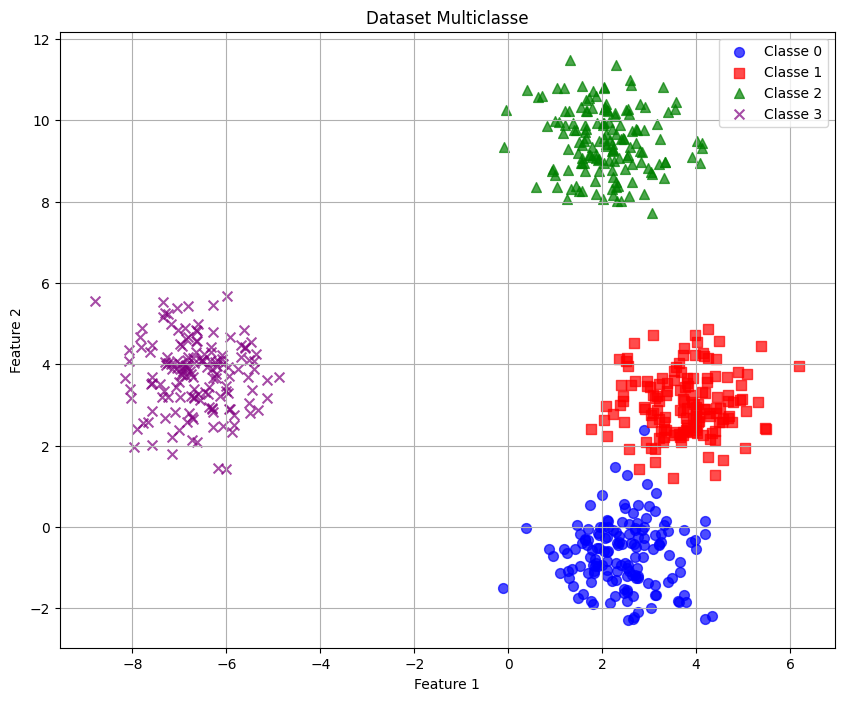

In [20]:
def create_multiclass_dataset(n_samples=600, n_classes=4, n_features=2, noise=0.5):
    """
    Crea un dataset multiclasse nello spazio delle feature
    
    Parametri:
    n_samples -- numero totale di campioni
    n_classes -- numero di classi
    n_features -- numero di feature
    noise -- livello di rumore nei dati
    
    Restituisce:
    X -- matrice delle feature di shape (n_samples, n_features)
    y -- vettore delle etichette di shape (n_samples,)
    """
    np.random.seed(42)
    
    # Numero di campioni per classe
    samples_per_class = n_samples // n_classes
    
    X = np.zeros((n_samples, n_features))
    y = np.zeros(n_samples, dtype=int)
    
    for i in range(n_classes):
        # Creiamo centri casuali per ogni classe
        center = np.random.randn(n_features) * 5
        
        # Indici per questa classe
        start_idx = i * samples_per_class
        end_idx = (i + 1) * samples_per_class
        
        # Generiamo punti attorno al centro
        X[start_idx:end_idx] = np.random.randn(samples_per_class, n_features) * noise + center
        y[start_idx:end_idx] = i
    
    # Mescoliamo i dati
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    
    return X, y

# Creiamo un dataset multiclasse
X_multi, y_multi = create_multiclass_dataset(n_samples=600, n_classes=4, noise=0.8)

# Visualizziamo il dataset
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange', 'cyan']
markers = ['o', 's', '^', 'x', 'd', '*']

for i in range(len(np.unique(y_multi))):
    plt.scatter(X_multi[y_multi == i, 0], X_multi[y_multi == i, 1], 
                color=colors[i % len(colors)], marker=markers[i % len(markers)], 
                s=50, alpha=0.7, label=f'Classe {i}')

plt.title('Dataset Multiclasse')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

## 3. Confronto tra OVA e OVO

Addestriamo e confrontiamo i due approcci multiclasse:

In [21]:
def compare_ova_ovo(X_train, y_train, X_test, y_test, svm_class, **kwargs):
    """
    Confronta le performance di classificatori SVM multiclasse OVA e OVO.
    
    Parametri:
    ----------
    X_train : array-like
        Features del training set.
    y_train : array-like
        Labels del training set.
    X_test : array-like
        Features del test set.
    y_test : array-like
        Labels del test set.
    svm_class : class
        Classe del classificatore SVM base da utilizzare (es. LinearSVM, KernelSVM).
    **kwargs : dict
        Parametri aggiuntivi da passare al classificatore SVM.
    
    Returns:
    --------
    tuple
        (classificatore OVA addestrato, classificatore OVO addestrato,
         accuratezza OVA, accuratezza OVO)
    """
    # Creiamo e addestriamo il classificatore OVA
    ova_classifier = SVMMulticlassOVA(svm_class=svm_class, **kwargs)
    ova_classifier.fit(X_train, y_train)
    
    # Creiamo e addestriamo il classificatore OVO
    ovo_classifier = SVMMulticlassOVO(svm_class=svm_class, **kwargs)
    ovo_classifier.fit(X_train, y_train)
    
    # Facciamo predizioni
    y_pred_ova = ova_classifier.predict(X_test)
    y_pred_ovo = ovo_classifier.predict(X_test)
    
    # Calcoliamo le accuratezze
    from sklearn.metrics import accuracy_score
    accuracy_ova = accuracy_score(y_test, y_pred_ova)
    accuracy_ovo = accuracy_score(y_test, y_pred_ovo)
    
    # Stampiamo i risultati
    print(f"Accuratezza OVA: {accuracy_ova:.4f}")
    print(f"Accuratezza OVO: {accuracy_ovo:.4f}")
    
    # Visualizziamo le matrici di confusione
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1, 2, 1)
    cm_ova = confusion_matrix(y_test, y_pred_ova)
    sns.heatmap(cm_ova, annot=True, fmt='d', cmap='Blues',
               xticklabels=np.unique(y_train),
               yticklabels=np.unique(y_train))
    plt.title(f'Matrice di Confusione - OVA (Acc: {accuracy_ova:.4f})')
    plt.xlabel('Predetto')
    plt.ylabel('Reale')
    
    plt.subplot(1, 2, 2)
    cm_ovo = confusion_matrix(y_test, y_pred_ovo)
    sns.heatmap(cm_ovo, annot=True, fmt='d', cmap='Blues',
               xticklabels=np.unique(y_train),
               yticklabels=np.unique(y_train))
    plt.title(f'Matrice di Confusione - OVO (Acc: {accuracy_ovo:.4f})')
    plt.xlabel('Predetto')
    plt.ylabel('Reale')
    
    plt.tight_layout()
    plt.show()
    
    return ova_classifier, ovo_classifier, accuracy_ova, accuracy_ovo

Addestramento di 4 classificatori SVM (OVA)...
Classificatore 1/4 per classe 0 vs resto
Inizio addestramento SVM...
Addestramento completato in 3 steps!
Numero di support vectors: 10 su 450 punti (2.2%)
Norma del vettore w: 0.823012
Classificatore 2/4 per classe 1 vs resto
Inizio addestramento SVM...
Addestramento completato in 5 steps!
Numero di support vectors: 29 su 450 punti (6.4%)
Norma del vettore w: 0.200891
Classificatore 3/4 per classe 2 vs resto
Inizio addestramento SVM...
Addestramento completato in 3 steps!
Numero di support vectors: 6 su 450 punti (1.3%)
Norma del vettore w: 0.499840
Classificatore 4/4 per classe 3 vs resto
Inizio addestramento SVM...
Addestramento completato in 3 steps!
Numero di support vectors: 4 su 450 punti (0.9%)
Norma del vettore w: 0.268300
Addestramento OVA completato!
Addestramento di 4 classificatori SVM (OVA)...
Classificatore 1/4 per classe 0 vs resto
Inizio addestramento SVM...
Addestramento completato in 3 steps!
Numero di support vectors: 1

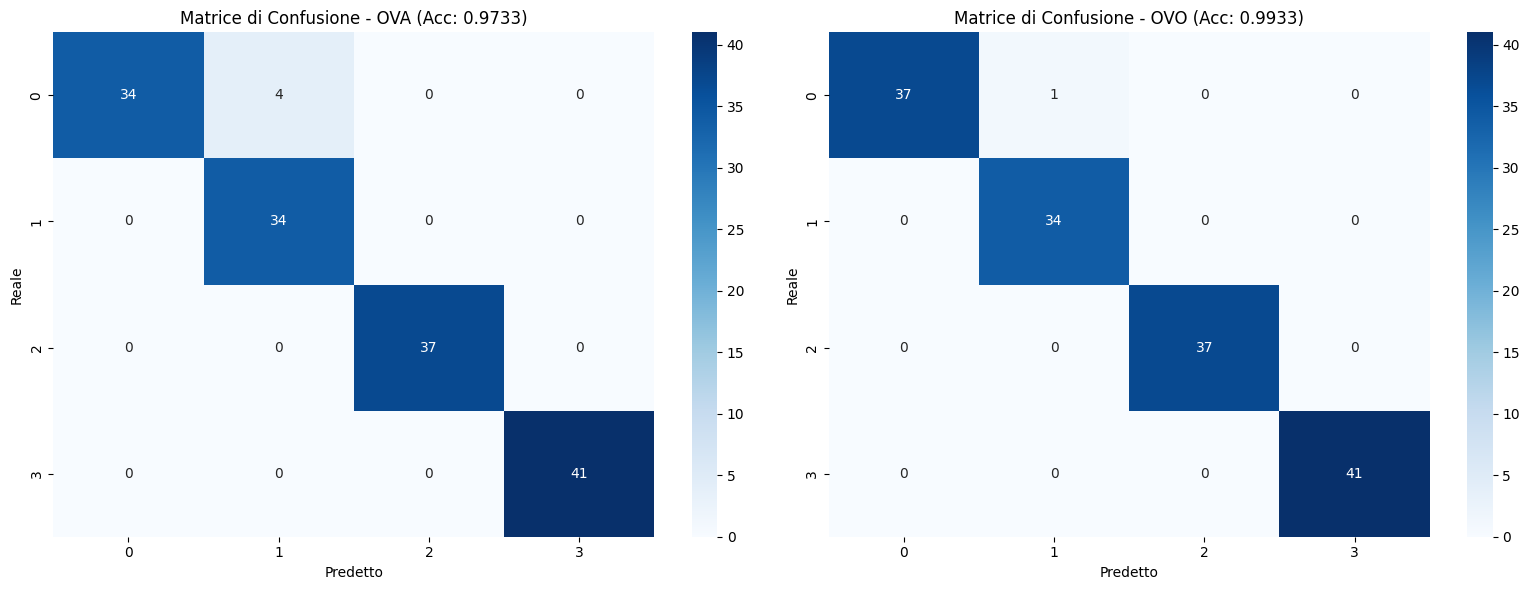

Addestramento di 6 classificatori SVM (OVO)...
Classificatore 1/6: classe 0 vs classe 1
Calcolo della matrice del kernel rbf...
Inizio addestramento SVM con kernel rbf usando SMO...
Addestramento completato in 3 passate!
Numero di support vectors: 7 su 228 punti (3.1%)
Classificatore 2/6: classe 0 vs classe 2
Calcolo della matrice del kernel rbf...
Inizio addestramento SVM con kernel rbf usando SMO...
Addestramento completato in 3 passate!
Numero di support vectors: 4 su 225 punti (1.8%)
Classificatore 3/6: classe 0 vs classe 3
Calcolo della matrice del kernel rbf...
Inizio addestramento SVM con kernel rbf usando SMO...
Addestramento completato in 3 passate!
Numero di support vectors: 4 su 221 punti (1.8%)
Classificatore 4/6: classe 1 vs classe 2
Calcolo della matrice del kernel rbf...
Inizio addestramento SVM con kernel rbf usando SMO...
Addestramento completato in 3 passate!
Numero di support vectors: 7 su 229 punti (3.1%)
Classificatore 5/6: classe 1 vs classe 3
Calcolo della matric

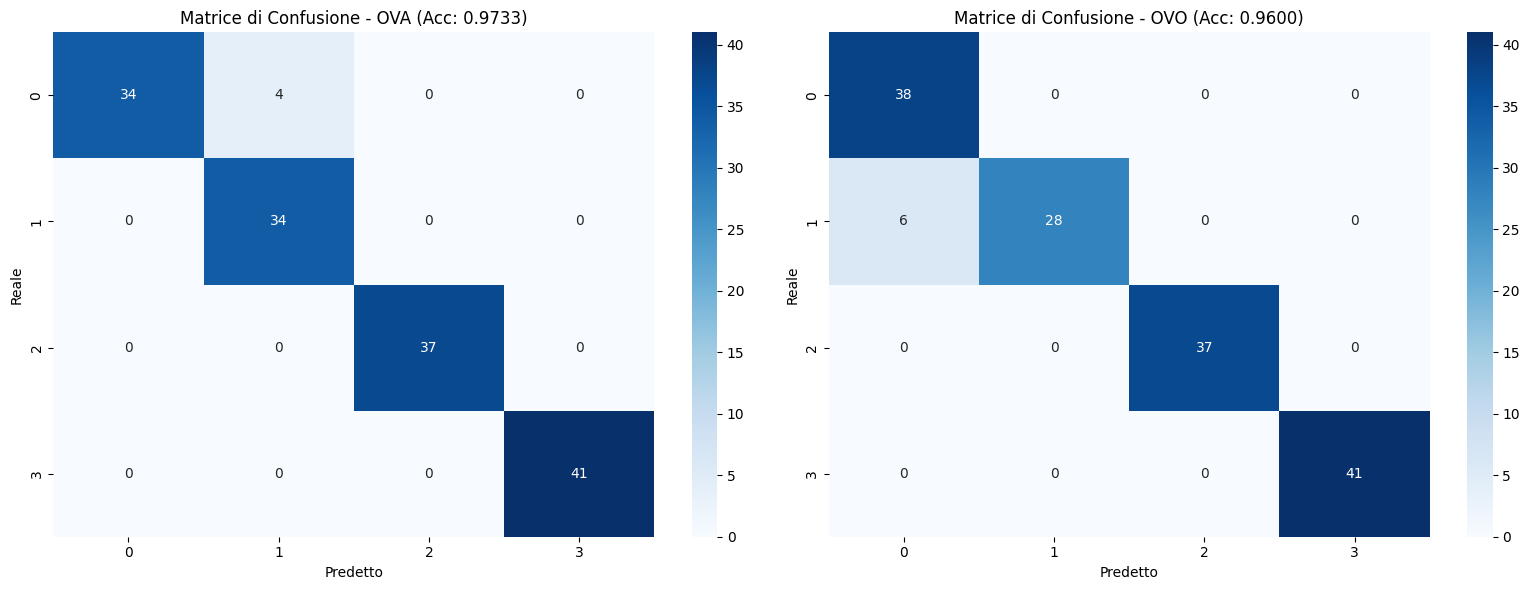

In [24]:
# Dividiamo il dataset in training e testing
np.random.seed(42)
indices = np.random.permutation(len(X_multi))
train_idx, test_idx = indices[:450], indices[450:]

X_train, y_train = X_multi[train_idx], y_multi[train_idx]
X_test, y_test = X_multi[test_idx], y_multi[test_idx]

# SVM parametri comuni
svm_params = {'C': 0.01}

# Addestriamo SVM multiclasse con OVA
ova_svm = SVMMulticlassOVA(svm_class=LinearSVM, C=1.0)
ova_svm.fit(X_train, y_train)

# Addestriamo SVM multiclasse con OVO
compare_ova_ovo(X_train, y_train, X_test, y_test, 
                                       svm_class=LinearSVM, C=1.0)
ovo_svm = SVMMulticlassOVO(svm_class=KernelSVM, kernel='rbf', C=1.0)
ovo_svm.fit(X_train, y_train)

# Facciamo predizioni
y_pred_ova = ova_svm.predict(X_test)
y_pred_ovo = ovo_svm.predict(X_test)

# Calcoliamo le accuratezze
accuracy_ova = accuracy_score(y_test, y_pred_ova)
accuracy_ovo = accuracy_score(y_test, y_pred_ovo)

print(f"\nAccuratezza OVA: {accuracy_ova:.4f}")
print(f"Accuratezza OVO: {accuracy_ovo:.4f}")

# Visualizziamo le matrici di confusione
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
cm_ova = confusion_matrix(y_test, y_pred_ova)
sns.heatmap(cm_ova, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_multi), 
            yticklabels=np.unique(y_multi))
plt.title(f'Matrice di Confusione - OVA (Acc: {accuracy_ova:.4f})')
plt.xlabel('Predetto')
plt.ylabel('Reale')

plt.subplot(1, 2, 2)
cm_ovo = confusion_matrix(y_test, y_pred_ovo)
sns.heatmap(cm_ovo, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_multi), 
            yticklabels=np.unique(y_multi))
plt.title(f'Matrice di Confusione - OVO (Acc: {accuracy_ovo:.4f})')
plt.xlabel('Predetto')
plt.ylabel('Reale')

plt.tight_layout()
plt.show()

## 4. Visualizzazione dei Decision Boundary Multiclasse

Visualizziamo i confini di decisione per entrambi gli approcci:

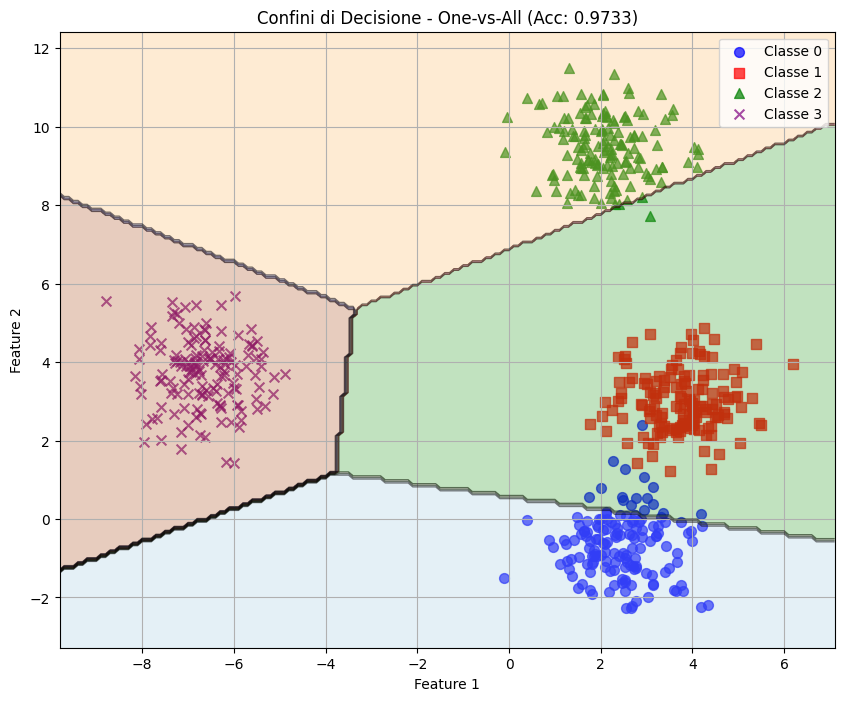


Esempio di voti per 3 istanze:
Istanza 0: 0: 1.0 1: 1.0 2: 1.0 3: 3.0 → Predizione: 3
Istanza 1: 0: 1.0 1: 1.0 2: 1.0 3: 3.0 → Predizione: 3
Istanza 2: 0: 1.0 1: 1.0 2: 1.0 3: 3.0 → Predizione: 3


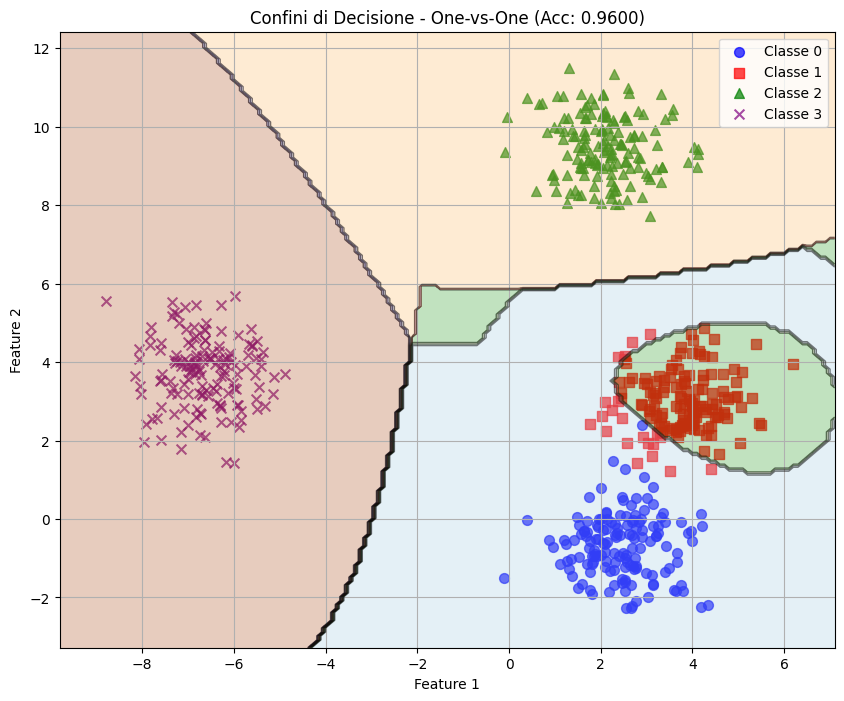

In [25]:
def plot_multiclass_decision_boundary(model, X, y, title, resolution=0.1):
    """
    Visualizza i confini di decisione per un modello multiclasse
    """
    plt.figure(figsize=(10, 8))
    
    # Plot dei punti
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'cyan']
    markers = ['o', 's', '^', 'x', 'd', '*']
    
    for i in range(len(np.unique(y))):
        plt.scatter(X[y == i, 0], X[y == i, 1], 
                    color=colors[i % len(colors)], marker=markers[i % len(markers)], 
                    s=50, alpha=0.7, label=f'Classe {i}')
    
    # Creiamo una griglia per visualizzare i confini di decisione
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    
    # Prediciamo la classe per ogni punto della griglia
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid_points)
    Z = Z.reshape(xx.shape)
    
    # Visualizziamo le regioni di decisione
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
    plt.contour(xx, yy, Z, colors='black', linewidths=1, alpha=0.5)
    
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualizziamo i confini di decisione
plot_multiclass_decision_boundary(ova_svm, X_multi, y_multi, 
                                 f'Confini di Decisione - One-vs-All (Acc: {accuracy_ova:.4f})')
plot_multiclass_decision_boundary(ovo_svm, X_multi, y_multi, 
                                 f'Confini di Decisione - One-vs-One (Acc: {accuracy_ovo:.4f})')

## 5. Confronto tra OVA e OVO: Vantaggi e Svantaggi

| Aspetto                           | One-vs-All (OVA)                         | One-vs-One (OVO)                                 |
| --------------------------------- | ---------------------------------------- | ------------------------------------------------ |
| **Numero di classificatori**      | K (numero di classi)                     | K(K-1)/2                                         |
| **Complessità computazionale**    | Più efficiente per poche classi          | Più efficiente per molte classi e dataset grandi |
| **Gestione dello sbilanciamento** | Peggiore (una classe vs. tutte le altre) | Migliore (ogni coppia è bilanciata)              |
| **Robustezza**                    | Più sensibile a classi sbilanciate       | Più robusto                                      |
| **Interpretabilità**              | Più facile interpretare                  | Più complesso (voto di maggioranza)              |
